In [16]:
import nest_asyncio

nest_asyncio.apply()

from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    ServiceContext,
)
from llama_index.core.evaluation import (
    DatasetGenerator,
    FaithfulnessEvaluator,
    RelevancyEvaluator
)
from llama_index.llms.azure_openai import AzureOpenAI

import openai
import time

# Load environment variables from .env file
import pandas as pd
from llama_index.core.evaluation import (
    RetrieverEvaluator,
    get_retrieval_results_df,
)
import os
import logging
import pandas as pd
from dotenv import load_dotenv
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.node_parser import SentenceSplitter
from datetime import datetime
from llama_index.core import (
    StorageContext, VectorStoreIndex, SimpleDirectoryReader, 
    get_response_synthesizer, Settings
)
import traceback
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
)
from llama_index.core.evaluation import generate_question_context_pairs, QueryResponseDataset
from llama_index.llms.openai import OpenAI

import nest_asyncio

nest_asyncio.apply()

from pathlib import Path
from llama_index.readers.file import PDFReader
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import VectorStoreIndex
from llama_index.llms.openai import OpenAI
import json
from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import IndexNode
from llama_index.core.embeddings import resolve_embed_model

######
import nest_asyncio
from llama_index.core import Settings

nest_asyncio.apply()
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import IndexNode
from llama_index.core.extractors import (
    SummaryExtractor,
    QuestionsAnsweredExtractor,
)

load_dotenv()
# Fetch API keys from environment variables
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
AZURE_API_KEY = os.getenv('AZURE_API_KEY')
AZURE_DEPLOYMENT_NAME = os.getenv("AZURE_DEPLOYMENT_NAME")
AZURE_API_VERSION = os.getenv("AZURE_API_VERSION")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")


embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-large-en-v1.5"
)

Settings.embed_model=embed_model

def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    columns = {
        "retrievers": [name],
        **{k: [full_df[k].mean()] for k in metrics},
    }

    metric_df = pd.DataFrame(columns)

    return metric_df

metrics = ["hit_rate", "mrr", "precision", "recall", "ap", "ndcg"]


In [ ]:
loader = PyMuPDFReader()
documents = loader.load('EUAIACT.pdf')

Settings.embed_model = embed_model

# To evaluate for each chunk size, we will first generate a set of 40 questions from first 20 pages.
eval_documents = documents[:20]
data_generator = DatasetGenerator.from_documents(documents)
eval_questions = data_generator.generate_questions_from_nodes(num = 50)

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

# Define service context for GPT-4 for evaluation
Settings.llm = llm_gpt4o
#service_context_gpt4 = ServiceContext.from_defaults(llm=llm_gpt4o)

faithfulness_gpt4 = FaithfulnessEvaluator(llm=llm_gpt4o)
relevancy_gpt4 = RelevancyEvaluator(llm=llm_gpt4o)

# Define function to calculate average response time, average faithfulness and average relevancy metrics for given chunk size
def evaluate_response_time_and_accuracy(chunk_size):
    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0

    # create vector index
    
    Settings.llm = llm_gpt35
    Settings.chunk_size = chunk_size
    embed_model = HuggingFaceEmbedding(
        model_name="BAAI/bge-large-en-v1.5"
    )
    Settings.embed_model = embed_model
    vector_index = VectorStoreIndex.from_documents(
        eval_documents, llm=llm_gpt35, chunk_size=chunk_size
    )

    query_engine = vector_index.as_query_engine()
    num_questions = len(eval_questions)

    for question in eval_questions:
        start_time = time.time()
        response_vector = query_engine.query(question)
        elapsed_time = time.time() - start_time
        
        faithfulness_result = faithfulness_gpt4.evaluate_response(
            response=response_vector
        ).passing
        
        relevancy_result = relevancy_gpt4.evaluate_response(
            query=question, response=response_vector
        ).passing

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions

    return average_response_time, average_faithfulness, average_relevancy

euaiact_eval_questions = eval_questions

# Iterate over different chunk sizes to evaluate the metrics to help fix the chunk size.
for chunk_size in [128, 256, 512, 1024, 2048]:
    avg_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size)
    print(f"Chunk size {chunk_size} - Average Response time: {avg_time:.4f}s, Average Faithfulness: {avg_faithfulness:.4f}, Average Relevancy: {avg_relevancy:.4f}")


In [ ]:
loader = PyMuPDFReader()
docs1 = loader.load('LL144_Definitions.pdf')
docs2 = loader.load('LL144.pdf')
documents = docs1 + docs2

Settings.embed_model = embed_model

# To evaluate for each chunk size, we will first generate a set of 40 questions from first 20 pages.
eval_documents = documents
data_generator = DatasetGenerator.from_documents(documents)
eval_questions = data_generator.generate_questions_from_nodes(num = 50)

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

# Define service context for GPT-4 for evaluation
Settings.llm = llm_gpt4o
#service_context_gpt4 = ServiceContext.from_defaults(llm=llm_gpt4o)

faithfulness_gpt4 = FaithfulnessEvaluator(llm=llm_gpt4o)
relevancy_gpt4 = RelevancyEvaluator(llm=llm_gpt4o)

# Define function to calculate average response time, average faithfulness and average relevancy metrics for given chunk size
def evaluate_response_time_and_accuracy(chunk_size):
    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0

    # create vector index
    Settings.llm = llm_gpt35
    Settings.chunk_size = chunk_size
    embed_model = HuggingFaceEmbedding(
        model_name="BAAI/bge-large-en-v1.5"
    )
    Settings.embed_model = embed_model
    vector_index = VectorStoreIndex.from_documents(
        eval_documents, llm=llm_gpt35, chunk_size=chunk_size
    )

    query_engine = vector_index.as_query_engine()
    num_questions = len(eval_questions)

    for question in eval_questions:
        start_time = time.time()
        response_vector = query_engine.query(question)
        elapsed_time = time.time() - start_time
        
        faithfulness_result = faithfulness_gpt4.evaluate_response(
            response=response_vector
        ).passing
        
        relevancy_result = relevancy_gpt4.evaluate_response(
            query=question, response=response_vector
        ).passing

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions

    return average_response_time, average_faithfulness, average_relevancy


ll144_eval_questions = eval_questions

# Iterate over different chunk sizes to evaluate the metrics to help fix the chunk size.
for chunk_size in [128, 256, 512, 1024, 2048]:
    avg_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size)
    print(f"Chunk size {chunk_size} - Average Response time: {avg_time:.4f}s, Average Faithfulness: {avg_faithfulness:.4f}, Average Relevancy: {avg_relevancy:.4f}")

In [ ]:
ll144_eval_questions = eval_questions

In [ ]:
# Iterate over different chunk sizes to evaluate the metrics to help fix the chunk size.
for chunk_size in [128, 256, 512, 1024, 2048]:
    avg_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size)
    print(f"Chunk size {chunk_size} - Average Response time: {avg_time:.4f}s, Average Faithfulness: {avg_faithfulness:.4f}, Average Relevancy: {avg_relevancy:.4f}")

In [20]:
# setup LLM
import giskard
from llama_index.llms.azure_openai import AzureOpenAI
from giskard.llm import set_llm_model, set_llm_api
from giskard.llm.client import get_default_client
from giskard.llm.client import set_llm_api, set_llm_model
from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
import os
from giskard.rag import KnowledgeBase, generate_testset, QATestset
#from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions
testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

llm_gpt35 = AzureOpenAI(
    deployment_name="gpt35",#AZURE_DEPLOYMENT_NAME,
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-large-en-v1.5"
)
Settings.embed_model = embed_model

set_llm_api("azure")
set_llm_model('gpt4o')
# You'll need to provide the name of the model that you've deployed
# Beware, the model provided must be capable of using function calls
client = get_default_client()
assert client._client._base_url == f'{os.environ["AZURE_OPENAI_ENDPOINT"]}/openai/'
assert client._client.api_key == os.environ["AZURE_OPENAI_API_KEY"]
assert client._client._api_version == os.environ["OPENAI_API_VERSION"]
assert client.model == "gpt4o"#os.environ["AZURE_OPENAI_CHATGPT_DEPLOYMENT"]

In [135]:
%pip install langchain_core.utils

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement langchain_core.utils (from versions: none)
ERROR: No matching distribution found for langchain_core.utils
Note: you may need to restart the kernel to use updated packages.


In [14]:
from giskard.rag import AgentAnswer
from giskard.rag import evaluate, RAGReport
from giskard.rag.metrics.ragas_metrics import ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision
from llama_index.core.base.llms.types import ChatMessage, MessageRole

In [74]:
# Evaluate with Giskard
Settings.llm=llm_gpt35
loader = PyMuPDFReader()
#file_extractor = {".pdf": loader}
documents1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
documents2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
documents = documents1 + documents2

chunk_size = 512
splitter = SentenceSplitter(chunk_size=chunk_size)
index = VectorStoreIndex.from_documents(documents, llm=llm_gpt35, transformations=[splitter])
chat_engine = index.as_chat_engine(llm=llm_gpt35)

In [75]:
nodes = splitter(documents)

In [8]:
# Load nodes W/ METADATA REFERENCES INSTEAD

# Evaluate with Giskard
loader = PyMuPDFReader()
#file_extractor = {".pdf": loader}
documents1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
documents2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
documents = documents1 + documents2


base_nodes = splitter.get_nodes_from_documents(documents)


extractors = [
    SummaryExtractor(summaries=["self"], show_progress=True),
    QuestionsAnsweredExtractor(questions=5, show_progress=True),
]

# run metadata extractor across base nodes, get back dictionaries
node_to_metadata = {}
for extractor in extractors:
    metadata_dicts = extractor.extract(base_nodes)
    for node, metadata in zip(base_nodes, metadata_dicts):
        if node.node_id not in node_to_metadata:
            node_to_metadata[node.node_id] = metadata
        else:
            node_to_metadata[node.node_id].update(metadata)


# cache metadata dicts
def save_metadata_dicts(path, data):
    with open(path, "w") as fp:
        json.dump(data, fp)


def load_metadata_dicts(path):
    with open(path, "r") as fp:
        data = json.load(fp)
    return data

#save_metadata_dicts("metadata_dicts.json", node_to_metadata)
metadata_dicts = load_metadata_dicts("metadata_dicts.json")


# all nodes consists of source nodes, along with metadata
import copy

all_nodes = copy.deepcopy(base_nodes)
for node_id, metadata in node_to_metadata.items():
    for val in metadata.values():
        all_nodes.append(IndexNode(text=val, index_id=node_id))

all_nodes_dict = {n.node_id: n for n in all_nodes}

## Load index into vector index
from llama_index.core import VectorStoreIndex
from llama_index.llms.openai import OpenAI

index = VectorStoreIndex(all_nodes)
chat_engine = index.as_chat_engine(llm=llm_gpt35)

  0%|          | 0/24 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


### Generate a high level contents summary

In [18]:
import json
from llama_index.core import PromptTemplate

# Load the JSON file
with open('metadata_dicts.json', 'r') as file:
    data = json.load(file)

# Define the prompt template
contents_prompt = ("You are an expert key topic and entity extracting assistant that extracts topics, "
                   "from a chunk of text. Your aim is to extract {num_topics} key topics, entities and "
                   "concepts discussed in a chunk of text. Here are the guidelines you must follow: "
                   "- return a list of the extracted entities, with each on a new line "
                   "- do NOT use a numbered list or bullet points or dashes at all"                   
                   "- ensure your list covers all key concepts in the text, not just the most mentioned "
                   "- the topics/entities MUST be specifc'"
                   "- only return the final list, absolutely nothing else "
                   "- each line should be a maximum of 6-7 words"
                   
                   "Generate the list of {num_topics} entities based on this text: {section_summary} "
                   "List of entities:\n")

contents_prompt = PromptTemplate(contents_prompt)

# Define the generate_list function
def generate_list(llm, section_summary: str, num_topics: int = 5):
    fmt_content_prompt = contents_prompt.format(num_topics=num_topics, section_summary=section_summary)
    response = llm.complete(fmt_content_prompt)
    return response

topics_in_each_node = "Here are the topics covered in each node:\n"

# Loop through the first 3 document IDs and print the 'section_summary'
for doc_id in list(data.keys()):
    section_summary = data[doc_id]['section_summary']
    response = generate_list(llm=llm_gpt35, section_summary=section_summary, num_topics=3)
    topic_list = f"\n{response}"  #f"Document ID: {doc_id}
    topics_in_each_node += topic_list
    

print(topics_in_each_node)


Here are the topics covered in each node:

- New York City Department of Consumer and Worker Protection (DCWP)
- Commissioner of the DCWP
- New York City Charter
Bias Audit Requirements
Clarifications and Definitions
Public Feedback and Revisions
Impact Ratio Calculation
Data for Bias Audits
Shared Bias Audits
Automated Employment Decision Tool (AEDT)
Bias Audit
Candidate for Employment
Employers
Employment agencies
EEOC
Independent auditors
Bias Audit
Impact Ratio
Machine Learning, Statistical Modeling, Data Analytics, or Artificial Intelligence
- Scoring Rate
- Screen
- Selection Rate
- Definition of Test Data
- Bias Audit Requirement
- Audit Calculations
- Group Classification
- Exclusion of Unknown Categories
- Example Scenario
- Employers
- Employment agencies
- AEDTs
- Vendors conducting bias audits
Use of AEDT in hiring processes
Requirement for bias audits
Example of bias audit process
Metrics for evaluating bias (sex categories, number of applicants, number selected, selection

In [80]:
topics_in_each_node = """
- New York City Department of Consumer and Worker Protection (DCWP)
- Commissioner of the DCWP
- New York City Charter

Bias Audit Requirements
- Clarifications and Definitions
- Public Feedback and Revisions
- Impact Ratio Calculation
- Data for Bias Audits
- Shared Bias Audits

Automated Employment Decision Tool (AEDT)
- Bias Audit
- Candidate for Employment
- Employers
- Employment Agencies
- EEOC
- Independent Auditors
- Bias Audit
- Impact Ratio
- Machine Learning, Statistical Modeling, Data Analytics, or Artificial Intelligence

Scoring Rate
- Screen
- Selection Rate
- Definition of Test Data
- Bias Audit Requirement
- Audit Calculations
- Group Classification
- Exclusion of Unknown Categories
- Example Scenario

Employers
- Employment Agencies
- AEDTs
- Vendors Conducting Bias Audits
- Use of AEDT in Hiring Processes
- Requirement for Bias Audits
- Example of Bias Audit Process
- Metrics for Evaluating Bias (sex categories, number of applicants, number selected, selection rate, impact ratio)

Employer
- AEDT (Automated Employment Decision Tool)
- Vendor
- Independent Auditor
- Applicants (Male and Female)

Race/Ethnicity Categories
- Hispanic or Latino
- White (Not Hispanic or Latino)
- Black or African American (Not Hispanic or Latino)

Intersectional Categories
- Hispanic or Latino
- Non-Hispanic or Latino
- Male

Automated Employment Decision Tool (AEDT)
- Candidates for Employment
- Employees Being Considered for Promotion

Employers
- Independent Auditors
- Demographic Groups (sex, race/ethnicity, intersectional categories)
- Independent Auditor
- Employer
- Automated Employment Decision Tools (AEDTs)

Sex Categories
- Male
- Female

Race/Ethnicity Categories
- Hispanic or Latino
- White (Not Hispanic or Latino)
- Black or African American (Not Hispanic or Latino)
- Native Hawaiian or Pacific Islander (Not Hispanic or Latino)
- Asian (Not Hispanic or Latino)
- Native American or Alaska Native (Not Hispanic or Latino)
- Two or More Races (Not Hispanic or Latino)

Intersectional Categories
- Data Exclusion
- Historical Data Requirements
- Requirements for Conducting a Bias Audit

Automated Employment Decision Tool (AEDT)
- Use of Historical Data and Test Data
- Employment Agencies
- Employers
- AEDTs (Automated Employment Decision Tools)

Bias Audit Restrictions
- Published Results (§ 5-303)
- Notice to Candidates and Employees (§ 5-304)
- Automated Employment Decision Tool (AEDT)
- Employers and Employment Agencies
- Candidates for Employment

Employers
- Employment Agencies
- Candidates for Employment
- New York City Council
- Council Members
- Administrative Code of the City of New York

Bias Audit Requirement
- Notification Requirements
- Legal References
- Disclosure Requirements
- Penalties
- Enforcement

Office of Administrative Trials and Hearings
- City Agencies
- Corporation Counsel
- File #: Int 1894-2020
- New York City Commission on Human Rights
- Title 8
"""

topics_in_each_node = """
- New York City Department of Consumer and Worker Protection (DCWP)
- Commissioner of the DCWP
- New York City Charter
Bias Audit Requirements
Clarifications and Definitions
Public Feedback and Revisions
Impact Ratio Calculation
Data for Bias Audits
Shared Bias Audits
Automated Employment Decision Tool (AEDT)
Bias Audit
Candidate for Employment
Employers
Employment agencies
EEOC
Independent auditors
Bias Audit
Impact Ratio
Machine Learning, Statistical Modeling, Data Analytics, or Artificial Intelligence
- Scoring Rate
- Screen
- Selection Rate
- Definition of Test Data
- Bias Audit Requirement
- Audit Calculations
- Group Classification
- Exclusion of Unknown Categories
- Example Scenario
- Employers
- Employment agencies
- AEDTs
- Vendors conducting bias audits
Use of AEDT in hiring processes
Requirement for bias audits
Example of bias audit process
Metrics for evaluating bias (sex categories, number of applicants, number selected, selection rate, impact ratio)
Employer
AEDT (Automated Employment Decision Tool)
Vendor
Independent auditor
Applicants (Male and Female)
Race/Ethnicity Categories
Hispanic or Latino
White (Not Hispanic or Latino)
Black or African American (Not Hispanic or Latino)

Intersectional Categories
Hispanic or Latino
Non-Hispanic or Latino
Male
Automated Employment Decision Tool (AEDT)
Candidates for employment
Employees being considered for promotion
- Employers
- Independent auditors
- Demographic groups (sex, race/ethnicity, intersectional categories)
- Independent Auditor
- Employer
- Automated Employment Decision Tools (AEDTs)
- Sex Categories: Male, Female
- Race/Ethnicity Categories: Hispanic or Latino, White (Not Hispanic or Latino), Black or African American (Not Hispanic or Latino), Native Hawaiian or Pacific Islander (Not Hispanic or Latino), Asian (Not Hispanic or Latino), Native American or Alaska Native (Not Hispanic or Latino), Two or More Races (Not Hispanic or Latino)
Intersectional Categories
Data Exclusion
Historical Data Requirements
Requirements for conducting a bias audit
Automated Employment Decision Tool (AEDT)
Use of historical data and test data
Employment agencies
Employers
AEDTs (Automated Employment Decision Tools)
- Bias Audit Restrictions
- Published Results (§ 5-303)
- Notice to Candidates and Employees (§ 5-304)
- Automated Employment Decision Tool (AEDT)
- Employers and Employment Agencies
- Candidates for Employment
Employers
Employment agencies
Candidates for employment
New York City Council
Council Members
Administrative Code of the City of New York
- Bias Audit Requirement
- Notification Requirements
- Legal References
Disclosure Requirements
Penalties
Enforcement
Office of Administrative Trials and Hearings
City Agencies
Corporation Counsel
File #: Int 1894-2020
New York City Commission on Human Rights
title 8

"""

### Test Metadata + Prompt based Rewriter

#### Run this to use topic list

In [62]:
topics_in_each_node = """
- New York City Department of Consumer and Worker Protection (DCWP)
- Commissioner of the DCWP
- New York City Charter

Bias Audit Requirements
- Clarifications and Definitions
- Public Feedback and Revisions
- Impact Ratio Calculation
- Data for Bias Audits
- Shared Bias Audits

Automated Employment Decision Tool (AEDT)
- Bias Audit
- Candidate for Employment
- Employers
- Employment Agencies
- EEOC
- Independent Auditors
- Bias Audit
- Impact Ratio
- Machine Learning, Statistical Modeling, Data Analytics, or Artificial Intelligence

Scoring Rate
- Screen
- Selection Rate
- Definition of Test Data
- Bias Audit Requirement
- Audit Calculations
- Group Classification
- Exclusion of Unknown Categories
- Example Scenario

Employers
- Employment Agencies
- AEDTs
- Vendors Conducting Bias Audits
- Use of AEDT in Hiring Processes
- Requirement for Bias Audits
- Example of Bias Audit Process
- Metrics for Evaluating Bias (sex categories, number of applicants, number selected, selection rate, impact ratio)

Employer
- AEDT (Automated Employment Decision Tool)
- Vendor
- Independent Auditor
- Applicants (Male and Female)

Race/Ethnicity Categories
- Hispanic or Latino
- White (Not Hispanic or Latino)
- Black or African American (Not Hispanic or Latino)

Intersectional Categories
- Hispanic or Latino
- Non-Hispanic or Latino
- Male

Automated Employment Decision Tool (AEDT)
- Candidates for Employment
- Employees Being Considered for Promotion

Employers
- Independent Auditors
- Demographic Groups (sex, race/ethnicity, intersectional categories)
- Independent Auditor
- Employer
- Automated Employment Decision Tools (AEDTs)

Sex Categories
- Male
- Female

Race/Ethnicity Categories
- Hispanic or Latino
- White (Not Hispanic or Latino)
- Black or African American (Not Hispanic or Latino)
- Native Hawaiian or Pacific Islander (Not Hispanic or Latino)
- Asian (Not Hispanic or Latino)
- Native American or Alaska Native (Not Hispanic or Latino)
- Two or More Races (Not Hispanic or Latino)

Intersectional Categories
- Data Exclusion
- Historical Data Requirements
- Requirements for Conducting a Bias Audit

Automated Employment Decision Tool (AEDT)
- Use of Historical Data and Test Data
- Employment Agencies
- Employers
- AEDTs (Automated Employment Decision Tools)

Bias Audit Restrictions
- Published Results (§ 5-303)
- Notice to Candidates and Employees (§ 5-304)
- Automated Employment Decision Tool (AEDT)
- Employers and Employment Agencies
- Candidates for Employment

Employers
- Employment Agencies
- Candidates for Employment
- New York City Council
- Council Members
- Administrative Code of the City of New York

Bias Audit Requirement
- Notification Requirements
- Legal References
- Disclosure Requirements
- Penalties
- Enforcement

Office of Administrative Trials and Hearings
- City Agencies
- Corporation Counsel
- File #: Int 1894-2020
- New York City Commission on Human Rights
- Title 8
"""





You are an expert legal assistant that generates multiple search queries (e.g. keywords or key phrases) based on a single input query about a particular set of regulation. Your aim is to gather informationthat would contribute to a complete answer to the single query.You have been provided with a list of specific keywords and topics that are discussed in the knowledge base that the search queries will be applied to. Use these keywords to guide your generation of specific search queries and fill in any gaps.
- New York City Department of Consumer and Worker Protection (DCWP)
- Commissioner of the DCWP
- New York City Charter

Bias Audit Requirements
- Clarifications and Definitions
- Public Feedback and Revisions
- Impact Ratio Calculation
- Data for Bias Audits
- Shared Bias Audits

Automated Employment Decision Tool (AEDT)
- Bias Audit
- Candidate for Employment
- Employers
- Employment Agencies
- EEOC
- Independent Auditors
- Bias Audit
- Impact Ratio
- Machine Learning, Statistical 

In [81]:
query_gen_prompt_str = (

    "You are an expert legal assistant that generates multiple search queries (e.g. keywords or key phrases) based on a "
    "single input query about a particular set of regulation. Your aim is to gather information"
    "that would contribute to a complete answer to the single query."

    "You have been provided with a list of specific keywords and topics that are discussed in the knowledge "
    "base that the search queries will be applied to. Use these keywords to guide your generation of specific search queries and fill in any gaps."

    "{topics_in_each_node}"

    "Generate {num_queries} search queries, one on each line, "
   "related to the following input query and using the provided keywords appropriately:\n"
    "Query: {query}\n"
    "Queries:\n"
)

num_queries=6
query_str = query_gen_prompt_str
query_gen_prompt = PromptTemplate(query_gen_prompt_str)

fmt_prompt = query_gen_prompt.format(
    num_queries=num_queries - 1, query=query_str, topics_in_each_node=topics_in_each_node
)
print(fmt_prompt)

You are an expert legal assistant that generates multiple search queries (e.g. keywords or key phrases) based on a single input query about a particular set of regulation. Your aim is to gather informationthat would contribute to a complete answer to the single query.You have been provided with a list of specific keywords and topics that are discussed in the knowledge base that the search queries will be applied to. Use these keywords to guide your generation of specific search queries and fill in any gaps.
- New York City Department of Consumer and Worker Protection (DCWP)
- Commissioner of the DCWP
- New York City Charter
Bias Audit Requirements
Clarifications and Definitions
Public Feedback and Revisions
Impact Ratio Calculation
Data for Bias Audits
Shared Bias Audits
Automated Employment Decision Tool (AEDT)
Bias Audit
Candidate for Employment
Employers
Employment agencies
EEOC
Independent auditors
Bias Audit
Impact Ratio
Machine Learning, Statistical Modeling, Data Analytics, or A

#### Run this to NOT use topic list

In [79]:
query_gen_prompt_str = (

    "You are an expert legal assistant that generates multiple search queries (e.g. keywords or key phrases) based on a "
    "single input query. Your aim is to generate search queries to gather information"
    "that would contribute to a complete answer to the original single query."

    "Generate {num_queries} search queries, one on each line, "
   "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

topics_in_each_node=None

num_queries=6
query_str = query_gen_prompt_str
query_gen_prompt = PromptTemplate(query_gen_prompt_str)

fmt_prompt = query_gen_prompt.format(
    num_queries=num_queries - 1, query=query_str, topics_in_each_node=topics_in_each_node
)
print(fmt_prompt)

You are an expert legal assistant that generates multiple search queries (e.g. keywords or key phrases) based on a single input query. Your aim is to generate search queries to gather informationthat would contribute to a complete answer to the original single query.Generate 5 search queries, one on each line, related to the following input query:
Query: You are an expert legal assistant that generates multiple search queries (e.g. keywords or key phrases) based on a single input query. Your aim is to generate search queries to gather informationthat would contribute to a complete answer to the original single query.Generate {num_queries} search queries, one on each line, related to the following input query:
Query: {query}
Queries:

Queries:



### One shot prompt, No topics

In [ ]:
query_gen_prompt_str = (

    "You are an expert legal assistant that generates multiple search queries (e.g. keywords or key phrases) based on a "
    "single input query. Your aim is to generate search queries to gather information"
    "that would contribute to a complete answer to the original single query."

    "Here is an example."
    "Original Question: "

    "Generate {num_queries} search queries, one on each line, "
   "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

topics_in_each_node=None

num_queries=6
query_str = query_gen_prompt_str
query_gen_prompt = PromptTemplate(query_gen_prompt_str)

fmt_prompt = query_gen_prompt.format(
    num_queries=num_queries - 1, query=query_str, topics_in_each_node=topics_in_each_node
)
print(fmt_prompt)

In [11]:
Settings.embed_model = embed_model

In [82]:
from typing import List
from llama_index.core import QueryBundle
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore
import asyncio
from tqdm.asyncio import tqdm
from llama_index.core import PromptTemplate
import time
from llama_index.retrievers.bm25 import BM25Retriever



#query_str = "What is a bias audit and why do I need to do one?"

#query_gen_prompt_str = (
#    "You are an expert legal assistant that generates multiple search queries based on a "
#    "single input query about a particular set of regulation. Your aim is to gather information"
#    "that would contribute to a complete answer to the single query, tailored to legal clients."
#    "Consider (if applicable) the following:"
#    "- definitions"
#    "- requirements"
#    "- scope"
#    "- jurisdiction"
#    "- penalties"
#    "Generate {num_queries} search queries, one on each line, "
#    "related to the following iput query:\n"
#    "Query: {query}\n"
#    "Queries:\n"
#)
import time


Settings.llm=llm_gpt35
query_gen_prompt = PromptTemplate(query_gen_prompt_str)

def generate_queries(llm, query_str: str, num_queries: int = 6, topics_in_each_node=topics_in_each_node):
    fmt_prompt = query_gen_prompt.format(
        num_queries=num_queries - 1, query=query_str, topics_in_each_node=topics_in_each_node
    )
    #print(fmt_prompt)
    #time.sleep(2)
    response = llm.complete(fmt_prompt)
    #time.sleep(2)
    queries = response.text.split("\n")
    print(queries)
    return queries

async def run_queries(queries, retrievers):
    """Run queries against retrievers."""
    tasks = []
    for query in queries:
        for i, retriever in enumerate(retrievers):
            tasks.append(retriever.aretrieve(query))

    task_results = await tqdm.gather(*tasks)

    results_dict = {}
    for i, (query, query_result) in enumerate(zip(queries, task_results)):
        results_dict[(query, i)] = query_result
    #print(results_dict)
    return results_dict

## vector retriever
vector_retriever = index.as_retriever(similarity_top_k=5)

## bm25 retriever
bm25_retriever = BM25Retriever.from_defaults(
    docstore=index.docstore, similarity_top_k=5
)

def fuse_results(results_dict, similarity_top_k: int = 5):
    """Fuse results."""
    k = 60.0  # `k` is a parameter used to control the impact of outlier rankings.
    fused_scores = {}
    text_to_node = {}

    # compute reciprocal rank scores
    for nodes_with_scores in results_dict.values():
        for rank, node_with_score in enumerate(
            sorted(
                nodes_with_scores, key=lambda x: x.score or 0.0, reverse=True
            )
        ):
            text = node_with_score.node.get_content()
            text_to_node[text] = node_with_score
            if text not in fused_scores:
                fused_scores[text] = 0.0
            fused_scores[text] += 1.0 / (rank + k)

    # sort results
    reranked_results = dict(
        sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    )

    # adjust node scores
    reranked_nodes: List[NodeWithScore] = []
    for text, score in reranked_results.items():
        reranked_nodes.append(text_to_node[text])
        reranked_nodes[-1].score = score

    return reranked_nodes[:similarity_top_k]


class FusionRetriever(BaseRetriever):
    """Ensemble retriever with fusion."""

    def __init__(
        self,
        llm,
        retrievers: List[BaseRetriever],
        similarity_top_k: int = 5,
    ) -> None:
        """Init params."""
        self._retrievers = retrievers
        self._similarity_top_k = similarity_top_k
        self._llm = llm
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve."""
        queries = generate_queries(
            self._llm, query_bundle.query_str, num_queries=2, topics_in_each_node=topics_in_each_node
        )

        results = asyncio.run(run_queries(queries, self._retrievers))

        final_results = fuse_results(
            results, similarity_top_k=self._similarity_top_k
        )
        print(f"final_results {final_results}")

        return final_results
    

from llama_index.core.query_engine import RetrieverQueryEngine

#fusion_retriever = FusionRetriever(
 #   llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=3
#)

# create vector index
text_nodes = splitter(documents)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)
retriever = FusionRetriever(
    llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=5)#index.as_retriever(similarity_top_k=5)

#retriever = create_adaptive_retriever(index=index, llm=llm_gpt35, similarity_top_k=10)


Settings.llm = llm_gpt4o
def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)

def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})
    print(f"question: {question}")
    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    print(f"answer: {answer}")
    retrieved_nodes = retriever.retrieve(question)
    print(f"retrieved nodes: {retrieved_nodes}")
    documents = [node.node.text for node in retrieved_nodes]
    print(f"documents: {documents}")

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )
testset = QATestset.load("../giskard_test_sets/LL144_Sample.jsonl")
report = evaluate(get_answer_fn,
                testset=testset,
                knowledge_base=knowledge_base,
                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

# Adaptive Method
#report.to_html("simple_rewriter_results.html")
results = report.to_pandas()
results.to_csv('rewriter_with_topics4.csv', index=False)
report.to_html("rewriter_with_topics4.html")

Asking questions to the agent:   0%|          | 0/10 [00:00<?, ?it/s]

question: As an employer, I need to understand the definition of 'Candidate for Employment' as stated in the legal documents. Can you provide me with the specific criteria that determine whether someone is considered a candidate for employment?
answer: According to the legal documents, a "Candidate for Employment" refers to individuals who are being considered or evaluated for a job position within the organization. This includes individuals who have applied for a position and are undergoing screening or assessment using an automated employment decision tool. The definition encompasses both potential new hires and existing employees who are being considered for promotion within the organization.
["- Definition of 'Candidate for Employment' in New York City Charter", "- Criteria for determining 'Candidate for Employment' in New York City Department of Consumer and Worker Protection (DCWP)", "- Definition and criteria for 'Candidate for Employment' in New York City Commission on Human Ri

Asking questions to the agent:  10%|█         | 1/10 [00:08<01:12,  8.08s/it]

final_results [NodeWithScore(node=TextNode(id_='7ec93afe-e11b-4afb-ae2c-60d79ca04a72', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL144.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='60ec5521-24b4-43fe-a02f-66b84e290bb2', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL144.pdf', 'source': '1'}, hash='4e0c3a4fd055b8cbce9ba46e58440ac8f05a34496ec263530292d2deb64e7096'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='0070791a-4fbd-4a84-8362-9d1370ebfaa4', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Department of Consumer and Worker Pro

Asking questions to the agent:  20%|██        | 2/10 [00:22<01:33, 11.72s/it]

final_results [NodeWithScore(node=TextNode(id_='7ec93afe-e11b-4afb-ae2c-60d79ca04a72', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL144.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='60ec5521-24b4-43fe-a02f-66b84e290bb2', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL144.pdf', 'source': '1'}, hash='4e0c3a4fd055b8cbce9ba46e58440ac8f05a34496ec263530292d2deb64e7096'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='0070791a-4fbd-4a84-8362-9d1370ebfaa4', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Department of Consumer and Worker Pro

Asking questions to the agent:  30%|███       | 3/10 [00:27<01:02,  8.87s/it]

final_results [NodeWithScore(node=TextNode(id_='da2730ba-218b-4406-8ff3-505c52293c81', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL144.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1133ea37-2346-4a24-aeba-2a7bc40d6841', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL144.pdf', 'source': '8'}, hash='92d0883a9ea1eb488adcb9710619f77cc821ad59541c0195ec0ad1699708b9c5'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='a73112f4-ec98-4bd6-8919-3856520c9d9e', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL144.pdf', 'source': '8'}, hash='c3d0cc7ed8fcbac5c2df8e5bb42f3f27404307902b6dd044ecd2bfdbb0a99faf')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must use historical \ndata of the AEDT

Asking questions to the agent:  30%|███       | 3/10 [00:28<01:06,  9.44s/it]


KeyboardInterrupt: 

#### Adaptive K value with TOpics

In [161]:
from typing import List
from llama_index.core import QueryBundle
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore
import asyncio
from tqdm.asyncio import tqdm
from llama_index.core import PromptTemplate
import time
from llama_index.retrievers.bm25 import BM25Retriever

# Define the single query generation prompt
query_gen_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "single input query about a particular set of regulation. Your aim is to gather information"
    "that would contribute to a complete answer to the single query."
    "You have been provided with a list of specific keywords that are discussed in the knowledge "
    "base that the search queries will be applied to. Use these keywords to guide your generation of specific search queries"
    "{topics_in_each_node}"
    "Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

query_gen_prompt = PromptTemplate(query_gen_prompt_str)

def classify_query(llm, query_str: str) -> str:
    classification_prompt = (
        "Classify the following query into one of three categories: "
        "A: a simple query covering just one topic, "
        "B: a complex query covering multiple topics, "
        "C: a complicated query that requires further reasoning ability\n"
        "Query: {query}\n"
        "Return only the query classification label (e.g. A,B,C), absolutely nothing else. Category:"
    )
    response = llm.complete(classification_prompt.format(query=query_str))
    return response.text.strip()

def generate_queries(llm, query_str: str, num_queries: int, topics_in_each_node):
    fmt_prompt = query_gen_prompt.format(
        num_queries=num_queries, query=query_str, topics_in_each_node=topics_in_each_node
    )
    response = llm.complete(fmt_prompt)
    queries = response.text.split("\n")
    return queries

async def run_queries(queries, retrievers):
    """Run queries against retrievers."""
    tasks = []
    for query in queries:
        for i, retriever in enumerate(retrievers):
            tasks.append(retriever.aretrieve(query))

    task_results = await tqdm.gather(*tasks)

    results_dict = {}
    for i, (query, query_result) in enumerate(zip(queries, task_results)):
        results_dict[(query, i)] = query_result
    return results_dict

## vector retriever
vector_retriever = index.as_retriever(similarity_top_k=10)

## bm25 retriever
bm25_retriever = BM25Retriever.from_defaults(
    docstore=index.docstore, similarity_top_k=10
)

def fuse_results(results_dict, similarity_top_k: int):
    """Fuse results."""
    k = 60.0  # `k` is a parameter used to control the impact of outlier rankings.
    fused_scores = {}
    text_to_node = {}

    # compute reciprocal rank scores
    for nodes_with_scores in results_dict.values():
        for rank, node_with_score in enumerate(
            sorted(
                nodes_with_scores, key=lambda x: x.score or 0.0, reverse=True)
        ):
            text = node_with_score.node.get_content()
            text_to_node[text] = node_with_score
            if text not in fused_scores:
                fused_scores[text] = 0.0
            fused_scores[text] += 1.0 / (rank + k)

    # sort results
    reranked_results = dict(
        sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    )

    # adjust node scores
    reranked_nodes: List[NodeWithScore] = []
    for text, score in reranked_results.items():
        reranked_nodes.append(text_to_node[text])
        reranked_nodes[-1].score = score

    return reranked_nodes[:similarity_top_k]

class FusionRetriever(BaseRetriever):
    """Ensemble retriever with fusion."""

    def __init__(
        self,
        llm,
        retrievers: List[BaseRetriever],
        similarity_top_k: int = 5,
    ) -> None:
        """Init params."""
        self._retrievers = retrievers
        self._similarity_top_k = similarity_top_k
        self._llm = llm
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve."""
        query_type = classify_query(self._llm, query_bundle.query_str)
        
        if query_type == 'A':
            num_queries = 4
            similarity_top_k = self._similarity_top_k
        elif query_type == 'B':
            num_queries = 6
            similarity_top_k = 7
        elif query_type == 'C':
            num_queries = 8
            similarity_top_k = 9
        else:
            raise ValueError("Unknown query type classification")

        queries = generate_queries(
            self._llm, query_bundle.query_str, num_queries=num_queries, topics_in_each_node=topics_in_each_node
        )

        results = asyncio.run(run_queries(queries, self._retrievers))

        final_results = fuse_results(
            results, similarity_top_k=similarity_top_k
        )

        return final_results

from llama_index.core.query_engine import RetrieverQueryEngine

# Example initialization and usage
# fusion_retriever = FusionRetriever(
#     llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=3
# )

# create vector index
text_nodes = splitter(documents)
knowledge_base_df = pd.DataFrame([node.text for node in all_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)
retriever = FusionRetriever(
    llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=5
)

Settings.llm = llm_gpt4o
def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] == "user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)

def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]

    return AgentAnswer(
        message=answer,
        documents=documents
    )

testset = QATestset.load("../giskard_test_sets/LL144_275_New.jsonl")
report = evaluate(get_answer_fn,
                testset=testset,
                knowledge_base=knowledge_base,
                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

results = report.to_pandas()
results.to_csv('adaptive_k_topics2.csv', index=False)
report.to_html("adaptive_k_topics2.html")


RagasMetric evaluation: 100%|██████████| 26/26 [11:15<00:00, 25.97s/it]


2024-07-30 16:24:39,059 pid:58004 MainThread giskard.rag  INFO     Finding topics in the knowledge base.
2024-07-30 16:24:45,982 pid:58004 MainThread giskard.rag  INFO     Found 5 topics in the knowledge base.


In [135]:
query_string = "why do i need a bias audit aand why should i even do it?"

print(generate_queries(llm=llm_gpt35, query_str=query_string, num_queries=6, topics_in_each_node=topics_in_each_node))
print(generate_queries(llm=llm_gpt35, query_str=query_string, num_queries=6, topics_in_each_node=None))

['1. "Benefits of conducting a bias audit in employment practices"', '2. "Importance of bias audits in promoting fair hiring practices"', '3. "Legal requirements for bias audits in New York City"', '4. "Impact of bias audits on reducing discrimination in the workplace"', '5. "Steps to conduct a comprehensive bias audit in employment processes"']
['1. "Benefits of conducting a bias audit in employment practices"', '2. "Importance of bias audits in promoting fair hiring practices"', '3. "Legal requirements for bias audits in New York City"', '4. "Impact of bias audits on reducing discrimination in the workplace"', '5. "Steps to conduct a comprehensive bias audit in employment processes"']
['1. "Importance of bias audit in regulatory compliance"', '2. "Benefits of conducting a bias audit in organizations"', '3. "Legal requirements for bias audits in workplace regulations"', '4. "Best practices for implementing a bias audit in organizations"', '5. "Impact of bias audits on diversity and in

['1. Consequences of not conducting a bias audit in compliance with regulations', '2. Legal implications of failing to perform a bias audit', '3. Penalties for not conducting a bias audit as required by law', '4. Impact of not conducting a bias audit on organizational liability', '5. Best practices for addressing bias in the absence of a formal audit process']
['1. Consequences of not conducting a bias audit in compliance with regulations', '2. Legal implications of failing to perform a bias audit', '3. Penalties for not conducting a bias audit as required by law', '4. Impact of not conducting a bias audit on organizational liability', '5. Best practices for addressing bias in the absence of a formal audit process']


In [85]:
results = report.to_pandas()
results.to_csv('ex.csv', index=False)

In [23]:
from typing import List
from llama_index.core import QueryBundle
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore
import asyncio
from tqdm.asyncio import tqdm
from llama_index.core import PromptTemplate
import time
from llama_index.retrievers.bm25 import BM25Retriever



#query_str = "What is a bias audit and why do I need to do one?"

query_gen_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "single input query about a particular set of regulation. Your aim is to gather information"
    "that would contribute to a complete answer to the single query, tailored to legal clients."
    "Consider (if applicable) the following:"
    "- definitions"
    "- requirements"
    "- scope"
    "- jurisdiction"
    "- penalties"
    "Generate {num_queries} search queries, one on each line, "
    "related to the following iput query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

query_gen_prompt = PromptTemplate(query_gen_prompt_str)

def generate_queries(llm, query_str: str, num_queries: int = 6):
    fmt_prompt = query_gen_prompt.format(
        num_queries=num_queries - 1, query=query_str
    )
    response = llm.complete(fmt_prompt)
    queries = response.text.split("\n")
    return queries

async def run_queries(queries, retrievers):
    """Run queries against retrievers."""
    tasks = []
    for query in queries:
        for i, retriever in enumerate(retrievers):
            tasks.append(retriever.aretrieve(query))

    task_results = await tqdm.gather(*tasks)

    results_dict = {}
    for i, (query, query_result) in enumerate(zip(queries, task_results)):
        results_dict[(query, i)] = query_result

    return results_dict

## vector retriever
vector_retriever = index.as_retriever(similarity_top_k=5)

## bm25 retriever
bm25_retriever = BM25Retriever.from_defaults(
    docstore=index.docstore, similarity_top_k=5
)

def fuse_results(results_dict, similarity_top_k: int = 5):
    """Fuse results."""
    k = 60.0  # `k` is a parameter used to control the impact of outlier rankings.
    fused_scores = {}
    text_to_node = {}

    # compute reciprocal rank scores
    for nodes_with_scores in results_dict.values():
        for rank, node_with_score in enumerate(
            sorted(
                nodes_with_scores, key=lambda x: x.score or 0.0, reverse=True
            )
        ):
            text = node_with_score.node.get_content()
            text_to_node[text] = node_with_score
            if text not in fused_scores:
                fused_scores[text] = 0.0
            fused_scores[text] += 1.0 / (rank + k)

    # sort results
    reranked_results = dict(
        sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    )

    # adjust node scores
    reranked_nodes: List[NodeWithScore] = []
    for text, score in reranked_results.items():
        reranked_nodes.append(text_to_node[text])
        reranked_nodes[-1].score = score

    return reranked_nodes[:similarity_top_k]


class FusionRetriever(BaseRetriever):
    """Ensemble retriever with fusion."""

    def __init__(
        self,
        llm,
        retrievers: List[BaseRetriever],
        similarity_top_k: int = 5,
    ) -> None:
        """Init params."""
        self._retrievers = retrievers
        self._similarity_top_k = similarity_top_k
        self._llm = llm
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve."""
        queries = generate_queries(
            self._llm, query_bundle.query_str, num_queries=4
        )
        results = asyncio.run(run_queries(queries, self._retrievers))
        final_results = fuse_results(
            results, similarity_top_k=self._similarity_top_k
        )

        return final_results
    

from llama_index.core.query_engine import RetrieverQueryEngine

#fusion_retriever = FusionRetriever(
 #   llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=3
#)

In [61]:
from typing import List
from llama_index.core import QueryBundle
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore
import asyncio
from tqdm.asyncio import tqdm
from llama_index.core import PromptTemplate
import time
from llama_index.retrievers.bm25 import BM25Retriever

# Define the query generation prompts
simple_fact_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "single input query about a single particular topic. Your aim is to gather information"
    "that would contribute to a complete answer to the query, tailored to legal clients."
    "Consider (if applicable) the following:"
    "- definitions"
    "- requirements and scope"
    "- applied examples"
    "Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

multi_fact_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "complex input query about multiple facts in a particular set of regulations. Your aim is to gather information"
    "that would contribute to a complete answer to the single query, tailored to legal clients."
    "Consider (if applicable) the following for each topic of interest in the query:"
    "- definitions"
    "- requirements"
    "- scope"
    "- jurisdiction"
    "- penalties"
    "- possible applications"
    "- examples"
    "Generate {num_queries} search queries, each focusing on different aspects of the facts, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

multi_step_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "multi-step input query about the application of rules and what the appropriate conclusion might be for"
    "a particular set of regulations. Your aim is to gather informatio that would contribute to a complete"
    "answer to the original query, tailored to legal clients."
    "Consider (if applicable) the following for each step:"
    "- rule to be applied"
    "- relevant requirements and conditions"
    "- scope and jurisdiction of the rule"
    "- enforcement guidelines and penalties"
    "- examples (possibly)"
    "Additionally, retrieve information on different rules that might be applied."
    "Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

# Create prompt templates
simple_fact_prompt = PromptTemplate(simple_fact_prompt_str)
multi_fact_prompt = PromptTemplate(multi_fact_prompt_str)
multi_step_prompt = PromptTemplate(multi_step_prompt_str)

def classify_query(llm, query_str: str) -> str:
    classification_prompt = (
        "Classify the following query into one of three categories: "
        "A: a simple fact-based retrieval query, "
        "B: a multi-fact based retrieval query, "
        "C: a multi-step rule-conclusion type question.\n"
        "Query: {query}\n"
        "Return only the query classification label (e.g. A,B,C), absolutely nothing else. Category:"
    )
    response = llm.complete(classification_prompt.format(query=query_str))
    return response.text.strip()

def generate_queries(llm, query_str: str, min_num_queries: int = 4):
    query_type = classify_query(llm, query_str)
    if query_type == 'A':
        num_queries = min_num_queries
        fmt_prompt = simple_fact_prompt.format(num_queries=num_queries - 1, query=query_str)
    elif query_type == 'B':
        num_queries = min_num_queries + 2
        fmt_prompt = multi_fact_prompt.format(num_queries=num_queries - 1, query=query_str)
    else: 
        query_type == 'C'
        num_queries = min_num_queries + 4
        fmt_prompt = multi_step_prompt.format(num_queries=num_queries - 1, query=query_str)
    
    response = llm.complete(fmt_prompt)
    queries = response.text.split("\n")
    return queries, query_type

async def run_queries(queries, retrievers):
    """Run queries against retrievers."""
    tasks = []
    for query in queries:
        for i, retriever in enumerate(retrievers):
            tasks.append(retriever.aretrieve(query))

    task_results = await tqdm.gather(*tasks)

    results_dict = {}
    for i, (query, query_result) in enumerate(zip(queries, task_results)):
        results_dict[(query, i)] = query_result

    return results_dict

## vector retriever
vector_retriever = index.as_retriever(similarity_top_k=10)

## bm25 retriever
bm25_retriever = BM25Retriever.from_defaults(
    docstore=index.docstore, similarity_top_k=10
)

def fuse_results(results_dict, similarity_top_k: int = 5):
    """Fuse results."""
    k = 60.0  # `k` is a parameter used to control the impact of outlier rankings.
    fused_scores = {}
    text_to_node = {}

    # compute reciprocal rank scores
    for nodes_with_scores in results_dict.values():
        for rank, node_with_score in enumerate(
            sorted(
                nodes_with_scores, key=lambda x: x.score or 0.0, reverse=True)
        ):
            text = node_with_score.node.get_content()
            text_to_node[text] = node_with_score
            if text not in fused_scores:
                fused_scores[text] = 0.0
            fused_scores[text] += 1.0 / (rank + k)

    # sort results
    reranked_results = dict(
        sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    )

    # adjust node scores
    reranked_nodes: List[NodeWithScore] = []
    for text, score in reranked_results.items():
        reranked_nodes.append(text_to_node[text])
        reranked_nodes[-1].score = score

    return reranked_nodes[:similarity_top_k]

class FusionRetriever(BaseRetriever):
    """Ensemble retriever with fusion."""

    def __init__(
        self,
        llm,
        retrievers: List[BaseRetriever],
        similarity_top_k: int = 5,
        min_num_queries: int = 4
    ) -> None:
        """Init params."""
        self._retrievers = retrievers
        self._min_similarity_top_k = similarity_top_k
        self._llm = llm
        self._min_num_queries = min_num_queries
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve."""
        queries, query_type = generate_queries(
            self._llm, query_bundle.query_str, min_num_queries=self._min_num_queries
        )
        
        if query_type == 'A':
            similarity_top_k = self._min_similarity_top_k
        elif query_type == 'B':
            similarity_top_k = 7
        elif query_type == 'C':
            similarity_top_k = 9
        else:
            raise ValueError("Unknown query type classification")
        
        results = asyncio.run(run_queries(queries, self._retrievers))
        final_results = fuse_results(
            results, similarity_top_k=similarity_top_k
        )
        print(final_results)
        return final_results

from llama_index.core.query_engine import RetrieverQueryEngine

#fusion_retriever = FusionRetriever(
 #   llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=3
#)


In [77]:
from typing import List
from llama_index.core import QueryBundle
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore
import asyncio
from tqdm.asyncio import tqdm
from llama_index.core import PromptTemplate
import time
from llama_index.retrievers.bm25 import BM25Retriever

# Define the query generation prompts
simple_fact_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "single input query about a single particular topic. Your aim is to gather information"
    "that would contribute to a complete answer to the query, tailored to legal clients."
    "Consider (if applicable) the following:"
    "- definitions"
    "- requirements and scope"
    "- applied examples"
    "Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

multi_fact_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "complex input query about multiple facts in a particular set of regulations. Your aim is to gather information"
    "that would contribute to a complete answer to the single query, tailored to legal clients."
    "Consider (if applicable) the following for each topic of interest in the query:"
    "- definitions"
    "- requirements"
    "- scope"
    "- jurisdiction"
    "- penalties"
    "- possible applications"
    "- examples"
    "Generate {num_queries} search queries, each focusing on different aspects of the facts, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

multi_step_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "multi-step input query about the application of rules and what the appropriate conclusion might be for"
    "a particular set of regulations. Your aim is to gather informatio that would contribute to a complete"
    "answer to the original query, tailored to legal clients."
    "Consider (if applicable) the following for each step:"
    "- rule to be applied"
    "- relevant requirements and conditions"
    "- scope and jurisdiction of the rule"
    "- enforcement guidelines and penalties"
    "- examples (possibly)"
    "Additionally, retrieve information on different rules that might be applied."
    "Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

query_gen_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "single input query about a particular set of regulation. Your aim is to gather information"
    "that would contribute to a complete answer to the single query, tailored to legal clients."
    "Consider (if applicable) the following:"
    "- definitions"
    "- requirements"
    "- scope"
    "- jurisdiction"
    "- penalties"
    "Generate {num_queries} search queries, one on each line, "
    "related to the following iput query:\n"
    "Query: {query}\n"
    "Queries:\n"
)


# Create prompt templates
simple_fact_prompt = PromptTemplate(simple_fact_prompt_str)
multi_fact_prompt = PromptTemplate(multi_fact_prompt_str)
multi_step_prompt = PromptTemplate(multi_step_prompt_str)

def classify_query(llm, query_str: str) -> str:
    classification_prompt = (
        "Classify the following query into one of three categories: "
        "A: a simple query covering just one topic, "
        "B: a complex query covering multiple topics, "
        "C: a complicated query that requires further reasoning ability\n"
        "Query: {query}\n"
        "Return only the query classification label (e.g. A,B,C), absolutely nothing else. Category:"
    )
    response = llm.complete(classification_prompt.format(query=query_str))
    return response.text.strip()

def generate_queries(llm, query_str: str, min_num_queries: int = 4):
    query_type = classify_query(llm, query_str)
    if query_type == 'A':
        num_queries = min_num_queries
        fmt_prompt = simple_fact_prompt.format(num_queries=num_queries, query=query_str)
    elif query_type == 'B':
        num_queries = min_num_queries + 2
        fmt_prompt = multi_fact_prompt.format(num_queries=num_queries, query=query_str)
    elif query_type == 'C':
        num_queries = min_num_queries + 4
        fmt_prompt = multi_step_prompt.format(num_queries=num_queries, query=query_str)
    else:
        raise ValueError("Unknown query type classification")
    
    response = llm.complete(fmt_prompt)
    queries = response.text.split("\n")
    return queries, query_type

async def run_queries(queries, retrievers):
    """Run queries against retrievers."""
    tasks = []
    for query in queries:
        for i, retriever in enumerate(retrievers):
            tasks.append(retriever.aretrieve(query))

    task_results = await tqdm.gather(*tasks)

    results_dict = {}
    for i, (query, query_result) in enumerate(zip(queries, task_results)):
        results_dict[(query, i)] = query_result

    return results_dict

## vector retriever
vector_retriever = index.as_retriever(similarity_top_k=10)

## bm25 retriever
bm25_retriever = BM25Retriever.from_defaults(
    docstore=index.docstore, similarity_top_k=10
)

def fuse_results(results_dict, similarity_top_k: int):
    """Fuse results."""
    k = 60.0  # `k` is a parameter used to control the impact of outlier rankings.
    fused_scores = {}
    text_to_node = {}

    # compute reciprocal rank scores
    for nodes_with_scores in results_dict.values():
        for rank, node_with_score in enumerate(
            sorted(
                nodes_with_scores, key=lambda x: x.score or 0.0, reverse=True)
        ):
            text = node_with_score.node.get_content()
            text_to_node[text] = node_with_score
            if text not in fused_scores:
                fused_scores[text] = 0.0
            fused_scores[text] += 1.0 / (rank + k)

    # sort results
    reranked_results = dict(
        sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    )

    # adjust node scores
    reranked_nodes: List[NodeWithScore] = []
    for text, score in reranked_results.items():
        reranked_nodes.append(text_to_node[text])
        reranked_nodes[-1].score = score

    return reranked_nodes[:similarity_top_k]

class FusionRetriever(BaseRetriever):
    """Ensemble retriever with fusion."""

    def __init__(
        self,
        llm,
        retrievers: List[BaseRetriever],
        similarity_top_k: int = 5,
        min_num_queries: int = 4
    ) -> None:
        """Init params."""
        self._retrievers = retrievers
        self._min_similarity_top_k = similarity_top_k
        self._llm = llm
        self._min_num_queries = min_num_queries
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve."""
        queries, query_type = generate_queries(
            self._llm, query_bundle.query_str, min_num_queries=self._min_num_queries
        )
        
        if query_type == 'A':
            similarity_top_k = self._min_similarity_top_k
        elif query_type == 'B':
            similarity_top_k = 7
        elif query_type == 'C':
            similarity_top_k = 9
        else:
            raise ValueError("Unknown query type classification")

        # Ensure the similarity_top_k is passed correctly to the retrievers and fusion
        results = asyncio.run(run_queries(queries, self._retrievers))
        final_results = fuse_results(
            results, similarity_top_k=similarity_top_k
        )
        print(f"Final results with similarity_top_k={similarity_top_k}: {final_results}")
        return final_results

from llama_index.core.query_engine import RetrieverQueryEngine

# Example initialization and usage
# fusion_retriever = FusionRetriever(
#     llm_gpt35, [vector_retriever, bm25_retriever], min_similarity_top_k=3
# )


In [78]:
chunk_size = 512
Settings.chunk_size = chunk_size
splitter = SentenceSplitter(chunk_size=chunk_size)
index = VectorStoreIndex.from_documents(documents, llm=llm_gpt35, transformations=[splitter])
chat_engine = index.as_chat_engine()

# create vector index
text_nodes = splitter(documents)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)
retriever = FusionRetriever(
    llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=5)#index.as_retriever(similarity_top_k=5)

#retriever = create_adaptive_retriever(index=index, llm=llm_gpt35, similarity_top_k=10)


Settings.llm = llm_gpt4o
def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)

def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    #print(answer)
    retrieved_nodes = retriever.retrieve(question)
    #print(retrieved_nodes)
    documents = [node.node.text for node in retrieved_nodes]
    #print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )
testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
report = evaluate(get_answer_fn,
                testset=testset,
                knowledge_base=knowledge_base,
                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

# Adaptive Method
#report.to_html("simple_rewriter_results.html")
results = report.to_pandas()
results.to_csv('adaptive_rewriter_k.csv', index=False)
report.to_html("adaptive_rewriter_k.csv")

Asking questions to the agent:   0%|          | 1/273 [00:08<37:20,  8.24s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:   1%|          | 2/273 [00:26<1:03:46, 14.12s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:   1%|          | 3/273 [00:33<48:05, 10.69s/it]  

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:   1%|▏         | 4/273 [00:39<40:35,  9.05s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:   2%|▏         | 5/273 [00:44<34:25,  7.71s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:   2%|▏         | 6/273 [01:00<46:40, 10.49s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:   3%|▎         | 7/273 [01:17<55:04, 12.42s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:   3%|▎         | 8/273 [01:25<49:00, 11.10s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:   3%|▎         | 9/273 [01:28<37:52,  8.61s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:   4%|▎         | 10/273 [01:42<44:59, 10.27s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:   4%|▍         | 11/273 [01:51<43:32,  9.97s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:   4%|▍         | 12/273 [02:01<42:51,  9.85s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:   5%|▍         | 13/273 [02:16<50:02, 11.55s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='98056871-ffda-40ba-838c-722fd9c4c2bd', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='679f8492-2e0f-4b69-b263-99f273a43649', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='cdff4e5845c89fc8017f1b9cb78a317bb542b3affa785283124f50b24b6a3551')}, text='8 \n \n \nIntersectional Categories \n \n \n \n# of \nApplicants \nScoring \nRate \nImpact \nRatio \nHispanic or Latino \nMale \n16 \n75% \n1.00 \nFemale \n12 \n50% \n0.67 \nNon

Asking questions to the agent:   5%|▌         | 14/273 [02:30<52:20, 12.12s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:   5%|▌         | 15/273 [02:41<50:25, 11.73s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:   6%|▌         | 16/273 [02:53<51:14, 11.96s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:   6%|▌         | 17/273 [03:04<49:25, 11.58s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:   7%|▋         | 18/273 [03:14<47:39, 11.21s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='588676dc-170a-4603-affa-2a734499e7ed', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='438ff506-39ec-4456-b0e0-4d04594e2fc8', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, hash='c7acb895b5676ef718067cd650891bb4059bef3e76b9b2f0ff707769926396dd')}, text='10 \n \n(2) Provide notice in a job posting at least 10 business days before use of an AEDT; or, \n(3) Provide notice via U.S. mail or e-mail at least 10 business days before use of an AEDT.  \n(d) To comply with § 20-871(b)(3) of the Code, an employer or employment agency must: \n(1) Provide information on the employment section of its website in a clear and conspicuous \nmanner about i

Asking questions to the agent:   7%|▋         | 19/273 [03:36<1:01:04, 14.43s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:   7%|▋         | 20/273 [03:42<49:41, 11.78s/it]  

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:   8%|▊         | 21/273 [03:57<53:33, 12.75s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:   8%|▊         | 22/273 [04:13<57:23, 13.72s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:   8%|▊         | 23/273 [04:23<52:38, 12.64s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:   9%|▉         | 24/273 [04:48<1:08:12, 16.44s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:   9%|▉         | 25/273 [04:58<1:00:09, 14.55s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  10%|▉         | 26/273 [05:03<47:39, 11.58s/it]  

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  10%|▉         | 27/273 [05:08<39:10,  9.56s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  10%|█         | 28/273 [05:13<33:20,  8.17s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  11%|█         | 29/273 [05:22<33:58,  8.35s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  11%|█         | 30/273 [05:23<25:55,  6.40s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:  11%|█▏        | 31/273 [05:31<26:45,  6.64s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  12%|█▏        | 32/273 [05:36<25:02,  6.23s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  12%|█▏        | 33/273 [05:42<25:17,  6.32s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  12%|█▏        | 34/273 [05:51<28:24,  7.13s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  13%|█▎        | 35/273 [06:00<29:37,  7.47s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  13%|█▎        | 36/273 [06:07<29:09,  7.38s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  14%|█▎        | 37/273 [06:13<27:41,  7.04s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  14%|█▍        | 38/273 [06:22<29:20,  7.49s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='79905a77-5a93-40c7-b477-87f208da5177', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8f99ef9c-94fe-4ed5-8b34-5948528eb8c1', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, hash='f14a6f95359af52d0a989740e9852bf3412a90cbb0d9cee78755b41a2064214d'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='0a7593a2-53e4-4ad4-9295-ac7ca8aa87ae', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='fd0c7514c24ad8608200d70b1d189660b3a84ab39c961fcfcf6611be9abd2c29')}, text='3 \n \nSection 1.  Chapter 5 of Title 6 of the Rules of the City of New York is amended to add Subchapter T to read \nas follows: \nSubchapter T: Automated Employment Decision T

Asking questions to the agent:  14%|█▍        | 39/273 [06:35<35:39,  9.15s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='588676dc-170a-4603-affa-2a734499e7ed', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='438ff506-39ec-4456-b0e0-4d04594e2fc8', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, hash='c7acb895b5676ef718067cd650891bb4059bef3e76b9b2f0ff707769926396dd')}, text='10 \n \n(2) Provide notice in a job posting at least 10 business days before use of an AEDT; or, \n(3) Provide notice via U.S. mail or e-mail at least 10 business days before use of an AEDT.  \n(d) To comply with § 20-871(b)(3) of the Code, an employer or employment agency must: \n(1) Provide information on the employment section of its website in a clear and conspicuous \nmanner about i

Asking questions to the agent:  15%|█▍        | 40/273 [06:42<33:35,  8.65s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  15%|█▌        | 41/273 [06:51<33:21,  8.63s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:  15%|█▌        | 42/273 [07:01<35:07,  9.12s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  16%|█▌        | 43/273 [07:07<31:14,  8.15s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:  16%|█▌        | 44/273 [07:17<33:46,  8.85s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  16%|█▋        | 45/273 [07:24<30:46,  8.10s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  17%|█▋        | 46/273 [07:31<29:31,  7.80s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  17%|█▋        | 47/273 [07:37<27:29,  7.30s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  18%|█▊        | 48/273 [07:42<24:31,  6.54s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  18%|█▊        | 49/273 [07:47<23:15,  6.23s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  18%|█▊        | 50/273 [07:53<23:11,  6.24s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  19%|█▊        | 51/273 [08:13<37:18, 10.08s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e4c2480b-6cae-4b77-9ea2-23071175322a', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='ab44bf92-f1d1-4004-9da1-453885d49ce4', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='0bdb3c4ec34275a5c54355c5c1de41c54c95e3aec4ad684eadc1dc6dccaf4ca4')}, text='5 \n \n \nTest data. “Test data” means data used to conduct a bias audit that is not historical data. \n§ 5-301 Bias Audit. \n(a) An employer or employment agency may not use or

Asking questions to the agent:  19%|█▉        | 52/273 [08:22<35:59,  9.77s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='9f64f627-10f4-4729-aeae-4565e6a732ff', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e2676675-168d-4c54-a2e8-c7c5ab5d2f3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, hash='ae59a347faf24ead7379983debd53df79af6bd05be3b4c241c1687cf3287b078'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='f8814fd2-9496-439f-bca5-32776b4dc50f', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a6f19a0dce301d801d29ccb5d3225c57c3392199b0851a5b271b634554918576')}, text='4 \n \niii. \nat any point during the bias audit, has a direct financial interest or a material indirect \nfinancial interest in an employer or employment agency that seeks to u

Asking questions to the agent:  19%|█▉        | 53/273 [08:24<27:31,  7.51s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:  20%|█▉        | 54/273 [08:38<35:10,  9.64s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  20%|██        | 55/273 [08:52<39:41, 10.92s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  21%|██        | 56/273 [08:56<31:31,  8.72s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='79905a77-5a93-40c7-b477-87f208da5177', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8f99ef9c-94fe-4ed5-8b34-5948528eb8c1', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, hash='f14a6f95359af52d0a989740e9852bf3412a90cbb0d9cee78755b41a2064214d'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='0a7593a2-53e4-4ad4-9295-ac7ca8aa87ae', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='fd0c7514c24ad8608200d70b1d189660b3a84ab39c961fcfcf6611be9abd2c29')}, text='3 \n \nSection 1.  Chapter 5 of Title 6 of the Rules of the City of New York is amended to add Subchapter T to read \nas follows: \nSubchapter T: Automated Employment Decision T

Asking questions to the agent:  21%|██        | 57/273 [09:11<37:59, 10.55s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  21%|██        | 58/273 [10:43<2:06:05, 35.19s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e4c2480b-6cae-4b77-9ea2-23071175322a', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='ab44bf92-f1d1-4004-9da1-453885d49ce4', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='0bdb3c4ec34275a5c54355c5c1de41c54c95e3aec4ad684eadc1dc6dccaf4ca4')}, text='5 \n \n \nTest data. “Test data” means data used to conduct a bias audit that is not historical data. \n§ 5-301 Bias Audit. \n(a) An employer or employment agency may not use or

Asking questions to the agent:  22%|██▏       | 59/273 [10:54<1:39:05, 27.78s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='588676dc-170a-4603-affa-2a734499e7ed', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='438ff506-39ec-4456-b0e0-4d04594e2fc8', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, hash='c7acb895b5676ef718067cd650891bb4059bef3e76b9b2f0ff707769926396dd')}, text='10 \n \n(2) Provide notice in a job posting at least 10 business days before use of an AEDT; or, \n(3) Provide notice via U.S. mail or e-mail at least 10 business days before use of an AEDT.  \n(d) To comply with § 20-871(b)(3) of the Code, an employer or employment agency must: \n(1) Provide information on the employment section of its website in a clear and conspicuous \nmanner about i

Asking questions to the agent:  22%|██▏       | 60/273 [11:00<1:15:27, 21.25s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  22%|██▏       | 61/273 [11:13<1:06:51, 18.92s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  23%|██▎       | 62/273 [11:26<59:45, 16.99s/it]  

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  23%|██▎       | 63/273 [11:40<56:33, 16.16s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e4c2480b-6cae-4b77-9ea2-23071175322a', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='ab44bf92-f1d1-4004-9da1-453885d49ce4', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='0bdb3c4ec34275a5c54355c5c1de41c54c95e3aec4ad684eadc1dc6dccaf4ca4')}, text='5 \n \n \nTest data. “Test data” means data used to conduct a bias audit that is not historical data. \n§ 5-301 Bias Audit. \n(a) An employer or employment agency may not use or

Asking questions to the agent:  23%|██▎       | 64/273 [11:56<56:19, 16.17s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  24%|██▍       | 65/273 [12:11<54:45, 15.79s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  24%|██▍       | 66/273 [12:25<52:24, 15.19s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  25%|██▍       | 67/273 [12:56<1:08:07, 19.84s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:  25%|██▍       | 68/273 [13:02<53:49, 15.75s/it]  

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  25%|██▌       | 69/273 [13:20<56:06, 16.50s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  26%|██▌       | 70/273 [13:30<48:55, 14.46s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:  26%|██▌       | 71/273 [13:43<47:32, 14.12s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  26%|██▋       | 72/273 [13:55<44:45, 13.36s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  27%|██▋       | 73/273 [14:08<44:38, 13.39s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  27%|██▋       | 74/273 [14:20<42:55, 12.94s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  27%|██▋       | 75/273 [14:27<37:02, 11.22s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  28%|██▊       | 76/273 [14:36<33:55, 10.33s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  28%|██▊       | 77/273 [14:45<33:00, 10.10s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:  29%|██▊       | 78/273 [15:04<41:47, 12.86s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:  29%|██▉       | 79/273 [15:12<36:42, 11.35s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  29%|██▉       | 80/273 [15:20<33:10, 10.31s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  30%|██▉       | 81/273 [15:38<40:28, 12.65s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  30%|███       | 82/273 [15:46<35:39, 11.20s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  30%|███       | 83/273 [15:56<34:41, 10.95s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:  31%|███       | 84/273 [16:05<31:59, 10.16s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  31%|███       | 85/273 [16:17<33:45, 10.77s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  32%|███▏      | 86/273 [16:25<30:52,  9.91s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  32%|███▏      | 87/273 [16:34<30:01,  9.69s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  32%|███▏      | 88/273 [16:46<31:48, 10.32s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  33%|███▎      | 89/273 [17:05<39:39, 12.93s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='ab44bf92-f1d1-4004-9da1-453885d49ce4', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e4c2480b-6cae-4b77-9ea2-23071175322a', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='e913b3347a4712dd56d85d6fc10ed0eada8cd95b7d8fc499646546b221827d14')}, text='Example: An employer wants to use an AEDT to screen resumes and schedule interviews for a job

Asking questions to the agent:  33%|███▎      | 90/273 [17:25<45:52, 15.04s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='588676dc-170a-4603-affa-2a734499e7ed', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='438ff506-39ec-4456-b0e0-4d04594e2fc8', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, hash='c7acb895b5676ef718067cd650891bb4059bef3e76b9b2f0ff707769926396dd')}, text='10 \n \n(2) Provide notice in a job posting at least 10 business days before use of an AEDT; or, \n(3) Provide notice via U.S. mail or e-mail at least 10 business days before use of an AEDT.  \n(d) To comply with § 20-871(b)(3) of the Code, an employer or employment agency must: \n(1) Provide information on the employment section of its website in a clear and conspicuous \nmanner about i

Asking questions to the agent:  33%|███▎      | 91/273 [17:34<40:12, 13.26s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  34%|███▎      | 92/273 [17:45<38:22, 12.72s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  34%|███▍      | 93/273 [17:58<38:12, 12.74s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  34%|███▍      | 94/273 [18:07<34:23, 11.53s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  35%|███▍      | 95/273 [18:15<31:17, 10.55s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:  35%|███▌      | 96/273 [18:25<30:49, 10.45s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  36%|███▌      | 97/273 [18:36<30:50, 10.52s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  36%|███▌      | 98/273 [18:54<37:22, 12.81s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  36%|███▋      | 99/273 [19:09<38:45, 13.37s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  37%|███▋      | 100/273 [19:26<41:30, 14.39s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='90a4f876-5ca4-40d3-ba87-5f6f63a6cc8e', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='dd10da008ee319b92dfde4748b1be51cabfad98b6dd2ec4a598e4e678998a0e9')}, text='9 \n \nExample 2: An employment agency has been using an AEDT for 6 months. The bias audit the \nemployment agency relied on before its first use of the AEDT was conducted 10 mo

Asking questions to the agent:  37%|███▋      | 101/273 [19:35<37:05, 12.94s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  37%|███▋      | 102/273 [19:45<34:16, 12.03s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  38%|███▊      | 103/273 [20:00<36:09, 12.76s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  38%|███▊      | 104/273 [20:14<36:56, 13.11s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  38%|███▊      | 105/273 [20:20<31:04, 11.10s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:  39%|███▉      | 106/273 [20:29<28:53, 10.38s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  39%|███▉      | 107/273 [20:48<36:20, 13.14s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='12dde721-d028-4c2c-86d5-7638fcbb7069', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='90a4f876-5ca4-40d3-ba87-5f6f63a6cc8e', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9f0826c71b532fa2b486b390005c160ca380188566187b85ae6744e7f0d1fdea'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='3a8f00fe-ec66-42c4-8958-42f15085df3f', node_t

Asking questions to the agent:  40%|███▉      | 108/273 [20:55<30:59, 11.27s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  40%|███▉      | 109/273 [21:12<35:39, 13.05s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  40%|████      | 110/273 [21:24<34:37, 12.75s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  41%|████      | 111/273 [21:30<28:57, 10.73s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  41%|████      | 112/273 [21:36<24:38,  9.18s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:  41%|████▏     | 113/273 [21:45<24:44,  9.28s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  42%|████▏     | 114/273 [21:53<23:23,  8.83s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  42%|████▏     | 115/273 [22:00<22:00,  8.36s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  42%|████▏     | 116/273 [22:17<28:14, 10.79s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='12dde721-d028-4c2c-86d5-7638fcbb7069', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='90a4f876-5ca4-40d3-ba87-5f6f63a6cc8e', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9f0826c71b532fa2b486b390005c160ca380188566187b85ae6744e7f0d1fdea'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='3a8f00fe-ec66-42c4-8958-42f15085df3f', node_t

Asking questions to the agent:  43%|████▎     | 117/273 [22:26<26:22, 10.14s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  43%|████▎     | 118/273 [22:34<24:47,  9.60s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  44%|████▎     | 119/273 [22:45<26:09, 10.19s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  44%|████▍     | 120/273 [22:56<26:23, 10.35s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  44%|████▍     | 121/273 [23:05<25:19,  9.99s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  45%|████▍     | 122/273 [23:14<24:11,  9.61s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  45%|████▌     | 123/273 [23:22<22:26,  8.98s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  45%|████▌     | 124/273 [23:33<24:01,  9.67s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='12dde721-d028-4c2c-86d5-7638fcbb7069', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='90a4f876-5ca4-40d3-ba87-5f6f63a6cc8e', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9f0826c71b532fa2b486b390005c160ca380188566187b85ae6744e7f0d1fdea'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='3a8f00fe-ec66-42c4-8958-42f15085df3f', node_t

Asking questions to the agent:  46%|████▌     | 125/273 [23:46<26:42, 10.83s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  46%|████▌     | 126/273 [24:08<34:20, 14.02s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  47%|████▋     | 127/273 [24:23<34:36, 14.23s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  47%|████▋     | 128/273 [24:33<31:41, 13.11s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  47%|████▋     | 129/273 [24:59<40:34, 16.90s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  48%|████▊     | 130/273 [25:14<38:52, 16.31s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  48%|████▊     | 131/273 [25:27<36:36, 15.47s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  48%|████▊     | 132/273 [25:37<32:16, 13.73s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  49%|████▊     | 133/273 [25:54<34:09, 14.64s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  49%|████▉     | 134/273 [26:25<45:24, 19.60s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  49%|████▉     | 135/273 [26:36<38:54, 16.92s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  50%|████▉     | 136/273 [26:48<35:49, 15.69s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  50%|█████     | 137/273 [27:02<34:00, 15.00s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  51%|█████     | 138/273 [27:18<34:28, 15.33s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  51%|█████     | 139/273 [27:35<35:38, 15.96s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  51%|█████▏    | 140/273 [27:52<36:08, 16.31s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  52%|█████▏    | 141/273 [28:14<39:26, 17.93s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:  52%|█████▏    | 142/273 [28:36<42:00, 19.24s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='12dde721-d028-4c2c-86d5-7638fcbb7069', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='90a4f876-5ca4-40d3-ba87-5f6f63a6cc8e', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9f0826c71b532fa2b486b390005c160ca380188566187b85ae6744e7f0d1fdea'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='3a8f00fe-ec66-42c4-8958-42f15085df3f', node_t

Asking questions to the agent:  52%|█████▏    | 143/273 [28:51<38:46, 17.90s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  53%|█████▎    | 144/273 [29:06<36:31, 16.99s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  53%|█████▎    | 145/273 [29:18<32:58, 15.46s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  53%|█████▎    | 146/273 [29:32<32:05, 15.16s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  54%|█████▍    | 147/273 [29:52<34:26, 16.40s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  54%|█████▍    | 148/273 [30:00<29:21, 14.09s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  55%|█████▍    | 149/273 [30:16<30:04, 14.55s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='79905a77-5a93-40c7-b477-87f208da5177', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8f99ef9c-94fe-4ed5-8b34-5948528eb8c1', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, hash='f14a6f95359af52d0a989740e9852bf3412a90cbb0d9cee78755b41a2064214d'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='0a7593a2-53e4-4ad4-9295-ac7ca8aa87ae', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='fd0c7514c24ad8608200d70b1d189660b3a84ab39c961fcfcf6611be9abd2c29')}, text='3 \n \nSection 1.  Chapter 5 of Title 6 of the Rules of the City of New York is amended to add Subchapter T to read \nas follows: \nSubchapter T: Automated Employment Decision T

Asking questions to the agent:  55%|█████▍    | 150/273 [30:24<25:50, 12.61s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  55%|█████▌    | 151/273 [30:27<19:53,  9.79s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  56%|█████▌    | 152/273 [30:31<16:17,  8.08s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='ab44bf92-f1d1-4004-9da1-453885d49ce4', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e4c2480b-6cae-4b77-9ea2-23071175322a', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='e913b3347a4712dd56d85d6fc10ed0eada8cd95b7d8fc499646546b221827d14')}, text='Example: An employer wants to use an AEDT to screen resumes and schedule interviews for a job

Asking questions to the agent:  56%|█████▌    | 153/273 [30:38<15:29,  7.74s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  56%|█████▋    | 154/273 [30:43<13:48,  6.96s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  57%|█████▋    | 155/273 [30:47<11:41,  5.95s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  57%|█████▋    | 156/273 [30:53<11:34,  5.94s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  58%|█████▊    | 157/273 [30:58<10:56,  5.66s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='0a7593a2-53e4-4ad4-9295-ac7ca8aa87ae', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8f99ef9c-94fe-4ed5-8b34-5948528eb8c1', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, hash='f14a6f95359af52d0a989740e9852bf3412a90cbb0d9cee78755b41a2064214d'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='79905a77-5a93-40c7-b477-87f208da5177', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, hash='22341a670eadcf2199b6b2279561f03e04e9b2b8b6508c1c71dc0178dfcb8230')}, text='Category. “Category” means any component 1 category required to be reported by employers purs

Asking questions to the agent:  58%|█████▊    | 158/273 [31:02<09:40,  5.04s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  58%|█████▊    | 159/273 [31:07<09:59,  5.26s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  59%|█████▊    | 160/273 [31:15<11:10,  5.93s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  59%|█████▉    | 161/273 [31:20<10:31,  5.64s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  59%|█████▉    | 162/273 [31:23<09:18,  5.03s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  60%|█████▉    | 163/273 [31:30<10:13,  5.58s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:  60%|██████    | 164/273 [31:33<08:37,  4.75s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='f8814fd2-9496-439f-bca5-32776b4dc50f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e2676675-168d-4c54-a2e8-c7c5ab5d2f3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, hash='ae59a347faf24ead7379983debd53df79af6bd05be3b4c241c1687cf3287b078'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9f64f627-10f4-4729-aeae-4565e6a732ff', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, hash='6295223b07e2e4123dd78d207e471c719b6c9026b0b568ec8490f97054c8129a')}, text='Scoring Rate. “Scoring Rate” means the rate at which individuals in a category receive a scor

Asking questions to the agent:  60%|██████    | 165/273 [31:38<08:28,  4.71s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  61%|██████    | 166/273 [31:44<09:10,  5.14s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  61%|██████    | 167/273 [31:47<08:16,  4.68s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='98056871-ffda-40ba-838c-722fd9c4c2bd', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='679f8492-2e0f-4b69-b263-99f273a43649', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='cdff4e5845c89fc8017f1b9cb78a317bb542b3affa785283124f50b24b6a3551')}, text='8 \n \n \nIntersectional Categories \n \n \n \n# of \nApplicants \nScoring \nRate \nImpact \nRatio \nHispanic or Latino \nMale \n16 \n75% \n1.00 \nFemale \n12 \n50% \n0.67 \nNon

Asking questions to the agent:  62%|██████▏   | 168/273 [31:53<08:47,  5.02s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='588676dc-170a-4603-affa-2a734499e7ed', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='438ff506-39ec-4456-b0e0-4d04594e2fc8', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '10'}, hash='c7acb895b5676ef718067cd650891bb4059bef3e76b9b2f0ff707769926396dd')}, text='10 \n \n(2) Provide notice in a job posting at least 10 business days before use of an AEDT; or, \n(3) Provide notice via U.S. mail or e-mail at least 10 business days before use of an AEDT.  \n(d) To comply with § 20-871(b)(3) of the Code, an employer or employment agency must: \n(1) Provide information on the employment section of its website in a clear and conspicuous \nmanner about i

Asking questions to the agent:  62%|██████▏   | 169/273 [32:01<10:15,  5.91s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='79905a77-5a93-40c7-b477-87f208da5177', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8f99ef9c-94fe-4ed5-8b34-5948528eb8c1', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '3'}, hash='f14a6f95359af52d0a989740e9852bf3412a90cbb0d9cee78755b41a2064214d'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='0a7593a2-53e4-4ad4-9295-ac7ca8aa87ae', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='fd0c7514c24ad8608200d70b1d189660b3a84ab39c961fcfcf6611be9abd2c29')}, text='3 \n \nSection 1.  Chapter 5 of Title 6 of the Rules of the City of New York is amended to add Subchapter T to read \nas follows: \nSubchapter T: Automated Employment Decision T

Asking questions to the agent:  62%|██████▏   | 170/273 [32:06<09:41,  5.65s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  63%|██████▎   | 171/273 [32:13<09:55,  5.84s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  63%|██████▎   | 172/273 [32:16<08:28,  5.04s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  63%|██████▎   | 173/273 [32:21<08:40,  5.20s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  64%|██████▎   | 174/273 [32:26<08:24,  5.10s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='ab44bf92-f1d1-4004-9da1-453885d49ce4', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e4c2480b-6cae-4b77-9ea2-23071175322a', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='e913b3347a4712dd56d85d6fc10ed0eada8cd95b7d8fc499646546b221827d14')}, text='Example: An employer wants to use an AEDT to screen resumes and schedule interviews for a job

Asking questions to the agent:  64%|██████▍   | 175/273 [32:40<12:23,  7.59s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  64%|██████▍   | 176/273 [33:07<21:51, 13.53s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  65%|██████▍   | 177/273 [33:13<18:01, 11.26s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  65%|██████▌   | 178/273 [33:30<20:37, 13.03s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  66%|██████▌   | 179/273 [33:47<22:13, 14.19s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  66%|██████▌   | 180/273 [33:54<18:35, 12.00s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  66%|██████▋   | 181/273 [34:17<23:25, 15.28s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  67%|██████▋   | 182/273 [34:31<22:49, 15.05s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='e4c2480b-6cae-4b77-9ea2-23071175322a', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='ab44bf92-f1d1-4004-9da1-453885d49ce4', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='0bdb3c4ec34275a5c54355c5c1de41c54c95e3aec4ad684eadc1dc6dccaf4ca4')}, text='5 \n \n \nTest data. “Test data” means data used to conduct a bias audit that is not historical data. \n§ 5-301 Bias Audit. \n(a) An employer or employment agency may not use or

Asking questions to the agent:  67%|██████▋   | 183/273 [34:49<23:51, 15.91s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='9f64f627-10f4-4729-aeae-4565e6a732ff', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e2676675-168d-4c54-a2e8-c7c5ab5d2f3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, hash='ae59a347faf24ead7379983debd53df79af6bd05be3b4c241c1687cf3287b078'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='f8814fd2-9496-439f-bca5-32776b4dc50f', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a6f19a0dce301d801d29ccb5d3225c57c3392199b0851a5b271b634554918576')}, text='4 \n \niii. \nat any point during the bias audit, has a direct financial interest or a material indirect \nfinancial interest in an employer or employment agency that seeks to u

Asking questions to the agent:  67%|██████▋   | 184/273 [35:03<22:39, 15.27s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  68%|██████▊   | 185/273 [35:14<20:26, 13.94s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  68%|██████▊   | 186/273 [35:31<21:38, 14.92s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  68%|██████▊   | 187/273 [35:49<22:41, 15.83s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:  69%|██████▉   | 188/273 [36:08<23:39, 16.70s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  69%|██████▉   | 189/273 [36:29<25:13, 18.02s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  70%|██████▉   | 190/273 [36:48<25:14, 18.25s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  70%|██████▉   | 191/273 [37:01<22:56, 16.79s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='f8814fd2-9496-439f-bca5-32776b4dc50f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e2676675-168d-4c54-a2e8-c7c5ab5d2f3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, hash='ae59a347faf24ead7379983debd53df79af6bd05be3b4c241c1687cf3287b078'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9f64f627-10f4-4729-aeae-4565e6a732ff', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, hash='6295223b07e2e4123dd78d207e471c719b6c9026b0b568ec8490f97054c8129a')}, text='Scoring Rate. “Scoring Rate” means the rate at which individuals in a category receive a scor

Asking questions to the agent:  70%|███████   | 192/273 [37:26<25:50, 19.14s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  71%|███████   | 193/273 [37:40<23:30, 17.63s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  71%|███████   | 194/273 [37:53<21:26, 16.29s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  71%|███████▏  | 195/273 [38:03<18:46, 14.44s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  72%|███████▏  | 196/273 [38:18<18:42, 14.58s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  72%|███████▏  | 197/273 [38:32<18:21, 14.49s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  73%|███████▎  | 198/273 [38:50<19:18, 15.45s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  73%|███████▎  | 199/273 [39:06<19:06, 15.49s/it]

Final results with similarity_top_k=7: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  73%|███████▎  | 200/273 [39:17<17:13, 14.16s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  74%|███████▎  | 201/273 [39:26<15:20, 12.78s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  74%|███████▍  | 202/273 [39:38<14:45, 12.47s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  74%|███████▍  | 203/273 [39:49<13:57, 11.96s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  75%|███████▍  | 204/273 [40:06<15:30, 13.49s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='ab44bf92-f1d1-4004-9da1-453885d49ce4', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e4c2480b-6cae-4b77-9ea2-23071175322a', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='e913b3347a4712dd56d85d6fc10ed0eada8cd95b7d8fc499646546b221827d14')}, text='Example: An employer wants to use an AEDT to screen resumes and schedule interviews for a job

Asking questions to the agent:  75%|███████▌  | 205/273 [40:14<13:24, 11.84s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:  75%|███████▌  | 206/273 [40:27<13:35, 12.17s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  76%|███████▌  | 207/273 [40:37<12:45, 11.60s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  76%|███████▌  | 208/273 [40:45<11:21, 10.48s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='a266e857-3b63-4d43-bce5-116cbf3ef94d', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='8dcc5dae-756a-4267-917f-8ecc620899df', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='57387770baf9c770452d6e7960051aa2a7f44aec1b4f6b2eecebeab694d9e9ab')}, text='(d) Notwithstanding the requirements of paragraphs (2) and (3) of subdivision (b) and paragra

Asking questions to the agent:  77%|███████▋  | 209/273 [40:59<12:13, 11.46s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  77%|███████▋  | 210/273 [41:09<11:36, 11.06s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='1b74b501-fa48-42a2-808e-51c49ea760c8', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='29ebed5e-b37b-4d6e-b267-078bf1467b01', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='d816e7a345fb5764677207a6257ea5e1af4ef5a1881c9864e7f75178effbf2e8')}, text='These rules establish that a bias audit of an AEDT must calculate the selection rate for each

Asking questions to the agent:  77%|███████▋  | 211/273 [41:19<11:05, 10.74s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  78%|███████▊  | 212/273 [41:37<13:11, 12.98s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  78%|███████▊  | 213/273 [41:41<10:22, 10.38s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  78%|███████▊  | 214/273 [41:55<11:21, 11.56s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  79%|███████▉  | 215/273 [42:02<09:45, 10.10s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  79%|███████▉  | 216/273 [42:11<09:15,  9.74s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  79%|███████▉  | 217/273 [42:22<09:26, 10.11s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  80%|███████▉  | 218/273 [42:29<08:31,  9.30s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='8dcc5dae-756a-4267-917f-8ecc620899df', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71ca6c5f-4325-4b56-b497-edfe4ebfd15c', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '7'}, hash='18484bde174a109f21499ebda02121d11bd12dbbd2d0149118754f4b74e21303'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a266e857-3b63-4d43-bce5-116cbf3ef94d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a08bdb7cbcd0de24c19fb77a58f6bae43ae2663a4e7e2fe8fa5fcd3b1f0abe9f')}, text='7 \n \n(3) Calculate the impact ratio for each category;  \n(4) Ensure that the calculations required in paragraphs (1), (2), and (3) of this subdivision \nseparately calculate 

Asking questions to the agent:  80%|████████  | 219/273 [42:44<09:45, 10.84s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='ab44bf92-f1d1-4004-9da1-453885d49ce4', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e4c2480b-6cae-4b77-9ea2-23071175322a', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='e913b3347a4712dd56d85d6fc10ed0eada8cd95b7d8fc499646546b221827d14')}, text='Example: An employer wants to use an AEDT to screen resumes and schedule interviews for a job

Asking questions to the agent:  81%|████████  | 220/273 [42:57<10:06, 11.44s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='29ebed5e-b37b-4d6e-b267-078bf1467b01', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='35c174e1-3313-488c-89b6-fa495fca3f07', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '1'}, hash='38e29bbb877a838db097438b6743582d6dfa91048ec322474f4cd59cb208203f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='1b74b501-fa48-42a2-808e-51c49ea760c8', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2936bc727a73735dd2843b69e6f84c3fad660564fdef685d5598bea94ab1d376')}, text='1 \n \nNew York City Department of Consumer and Worker Protection \n \nNotice of Adoption of Final Rule \n \nPursuant to the authority vested in the Commissioner of the Departme

Asking questions to the agent:  81%|████████  | 221/273 [43:04<08:55, 10.29s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e4c2480b-6cae-4b77-9ea2-23071175322a', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cb618b14-77a0-41f9-b020-a28aac22605a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '5'}, hash='d7833106e5891ed1250421d34ec2acdbfd9f63c3628eda1c1ab3dd651be9c258'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='ab44bf92-f1d1-4004-9da1-453885d49ce4', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='0bdb3c4ec34275a5c54355c5c1de41c54c95e3aec4ad684eadc1dc6dccaf4ca4')}, text='5 \n \n \nTest data. “Test data” means data used to conduct a bias audit that is not historical data. \n§ 5-301 Bias Audit. \n(a) An employer or employment agency may not use or

Asking questions to the agent:  81%|████████▏ | 222/273 [43:17<09:25, 11.09s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  82%|████████▏ | 223/273 [43:29<09:28, 11.37s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  82%|████████▏ | 224/273 [43:35<07:58,  9.77s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  82%|████████▏ | 225/273 [43:46<07:58,  9.97s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  83%|████████▎ | 226/273 [43:50<06:32,  8.35s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  83%|████████▎ | 227/273 [43:58<06:12,  8.10s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  84%|████████▎ | 228/273 [44:04<05:32,  7.39s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  84%|████████▍ | 229/273 [44:15<06:11,  8.44s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  84%|████████▍ | 230/273 [44:25<06:24,  8.95s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  85%|████████▍ | 231/273 [44:34<06:24,  9.17s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  85%|████████▍ | 232/273 [44:45<06:32,  9.56s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  85%|████████▌ | 233/273 [44:55<06:30,  9.75s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  86%|████████▌ | 234/273 [45:12<07:42, 11.85s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  86%|████████▌ | 235/273 [45:21<07:04, 11.17s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  86%|████████▋ | 236/273 [45:31<06:35, 10.69s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='f8814fd2-9496-439f-bca5-32776b4dc50f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e2676675-168d-4c54-a2e8-c7c5ab5d2f3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, hash='ae59a347faf24ead7379983debd53df79af6bd05be3b4c241c1687cf3287b078'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9f64f627-10f4-4729-aeae-4565e6a732ff', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '4'}, hash='6295223b07e2e4123dd78d207e471c719b6c9026b0b568ec8490f97054c8129a')}, text='Scoring Rate. “Scoring Rate” means the rate at which individuals in a category receive a scor

Asking questions to the agent:  87%|████████▋ | 237/273 [45:37<05:31,  9.21s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  87%|████████▋ | 238/273 [45:44<05:02,  8.63s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  88%|████████▊ | 239/273 [45:51<04:40,  8.24s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  88%|████████▊ | 240/273 [46:03<05:06,  9.29s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:  88%|████████▊ | 241/273 [46:17<05:45, 10.79s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  89%|████████▊ | 242/273 [46:26<05:14, 10.15s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='3a8f00fe-ec66-42c4-8958-42f15085df3f', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='13865c81-c7d0-4c79-9227-b3f1fc334370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='03c0444c71cb45f3c586a3d6cd961b0ccbb50764cdeca0ffde4ae3b686fc822c'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='12dde721-d028-4c2c-86d5-7638fcbb7069', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '9'}, hash='9fe30ea5c7a1889a1a2e9753a058654602e60b031db1369a2b4118216f3ee102')}, text='Nothing in this subchapter requires an employer or employment agency to provide an \nalternat

Asking questions to the agent:  89%|████████▉ | 243/273 [46:31<04:22,  8.74s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  89%|████████▉ | 244/273 [46:36<03:39,  7.57s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='679f8492-2e0f-4b69-b263-99f273a43649', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1da8aa45-34d0-4712-b96c-8b3e97eda1bb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='b83e4ae7fcb2c5c117e55fe919971f9f0ec6710593d15eb4b86ca2e5ff07057e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='98056871-ffda-40ba-838c-722fd9c4c2bd', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '8'}, hash='4eb1ca60b47b0679882f71a1589b385becffd4233b98ee2c57f7a1e9d8cd3c2a')}, text='(a) Historical Data. A bias audit conducted pursuant to section 5-301 of this Chapter must us

Asking questions to the agent:  90%|████████▉ | 245/273 [47:16<08:01, 17.19s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  90%|█████████ | 246/273 [47:24<06:28, 14.38s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  90%|█████████ | 247/273 [47:28<04:52, 11.26s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  91%|█████████ | 248/273 [47:35<04:11, 10.05s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='b7c08a10-9e98-46f7-9b1e-8fb31ff27def', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e5bf862a-229e-4e02-be3e-f656f735e6bd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '1'}, hash='79baf7f9c634b2e61677d4fbe60cee90e4ca3cbe3616c852a340a7b2f682e4c3')}, text='The New York City Council\nLegislation Text\nCity Hall\nNew York, NY  10007\nInt. No. 1894-A\nBy Council Members Cumbo, Ampry-Samuel, Rosenthal, Cornegy, Kallos, Adams, Louis, Chin, Cabrera, Rose,\nGibson, Brannan, Rivera, Levine, Ayala, Miller, Levin and Barron\nA Local Law to amend the administrative code of the city of New York, in relation to automated employment\ndec

Asking questions to the agent:  91%|█████████ | 249/273 [47:51<04:46, 11.93s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  92%|█████████▏| 250/273 [48:00<04:15, 11.13s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  92%|█████████▏| 251/273 [48:07<03:34,  9.76s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:  92%|█████████▏| 252/273 [48:18<03:35, 10.25s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  93%|█████████▎| 253/273 [48:25<03:05,  9.28s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  93%|█████████▎| 254/273 [48:37<03:11, 10.08s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  93%|█████████▎| 255/273 [48:46<02:54,  9.71s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  94%|█████████▍| 256/273 [49:02<03:14, 11.42s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  94%|█████████▍| 257/273 [49:05<02:25,  9.09s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  95%|█████████▍| 258/273 [49:17<02:28,  9.88s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  95%|█████████▍| 259/273 [49:21<01:53,  8.12s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e059737b-520e-43a9-855d-406ade848297', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='792d84a73645bcca3319892e598889c7f9acbdbda04dad6c01a6fff0d32ef53d')}, text='File #: Int 1894-2020, Version: A\n3. If not disclosed on the employer or employment agency’s website, information about the type of data\ncollected for the au

Asking questions to the agent:  95%|█████████▌| 260/273 [49:26<01:34,  7.25s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  96%|█████████▌| 261/273 [49:32<01:20,  6.69s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:  96%|█████████▌| 262/273 [49:39<01:14,  6.75s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  96%|█████████▋| 263/273 [49:50<01:20,  8.07s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  97%|█████████▋| 264/273 [50:00<01:17,  8.63s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent:  97%|█████████▋| 265/273 [50:07<01:06,  8.30s/it]

Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='e31f33a8-ac84-42f4-bea0-0bec11fc1173', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7575917a-61b4-49a9-9b1b-2e483e6f3f2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='56df65a939acf4f7fcda4c2a087a30d467a999bcdf052c24985035261655e4ee'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='9bd5df3d-2123-48f4-9bd6-66c1febd34c5', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '6'}, hash='990dd6e81da4a0de109b4ada0953797beb334c3fe690159efbfade84148da1b4')}, text='Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT s

Asking questions to the agent:  97%|█████████▋| 266/273 [50:14<00:55,  7.99s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  98%|█████████▊| 267/273 [50:21<00:45,  7.60s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

Asking questions to the agent:  98%|█████████▊| 268/273 [50:26<00:34,  6.90s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  99%|█████████▊| 269/273 [50:37<00:32,  8.08s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='014c01e9-4df6-418a-a039-d1de3e9fc9d1', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='81587f63-f4ac-4245-b964-698e18b62a34', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '2'}, hash='fb75fe53bede11808ed6a445079376e4060e305bc2786ca3df75f13bb33a5074')}, text='File #: Int 1894-2020, Version: A\naudit shall include but not be limited to the testing of an automated employment decision tool to assess the\ntool’s disparate impact on persons of any component 1 category required to be reported by employers pursuant\nto subsection (c) of section 2000e-8 of title 42 of the United States code as specified in part 1602.7 of title 29 of\n

Asking questions to the agent:  99%|█████████▉| 270/273 [50:44<00:22,  7.56s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='810c1102-e73a-4970-aef2-6b390b7c8ef1', embedding=None, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4056dadc-12c2-49cc-a181-38eb56e5b32b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 10, 'file_path': '../legal_data/LL144/LL14421.pdf', 'source': '2'}, hash='b7986da05396598d2a2a18015bfe532057f0fd0a59c139505d63fa8324f70c34')}, text='2 \n \n\uf0b7 \nClarifying that the required “impact ratio” must be calculated separately to compare sex categories, \nrace/ethnicity categories, and intersectional categories; \n\uf0b7 \nClarifying the types of data that may be used to conduct a bias audit; \n\uf0b7 \nClarifying that multiple employers using the same AEDT may rely on the same bias audit so long as they \nprovide historica

Asking questions to the agent:  99%|█████████▉| 271/273 [50:51<00:15,  7.55s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent: 100%|█████████▉| 272/273 [50:59<00:07,  7.57s/it]

Final results with similarity_top_k=9: [NodeWithScore(node=TextNode(id_='2968f4b1-8e44-4189-902f-8f62cb8c9d1e', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9ac5a3af-6771-4704-8902-cb73e6e85c3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='9eeb3fb7cadc828a5f50619276f14ed54bf6d4c9ee0e339d837ee2653b4d575e'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e059737b-520e-43a9-855d-406ade848297', node_type=<ObjectType.TEXT: '1'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '3'}, hash='242caa35da8e200ecb7ae701d778542eb7cc5650334214ea05f5c6fb74b357b7')}, text='d. A proceeding to recover any civil penalty authorized by this su

Asking questions to the agent: 100%|██████████| 273/273 [51:02<00:00, 11.22s/it]


Final results with similarity_top_k=5: [NodeWithScore(node=TextNode(id_='457fb977-71f8-4f76-8905-5c0c09919543', embedding=None, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4dc0d62d-d793-4519-b762-9c6fc231f955', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'total_pages': 4, 'file_path': '../legal_data/LL144/LL144_Definitions.pdf', 'source': '4'}, hash='d52290c226ac3202793838a487756db0aa49a17ccaa52f3f3f89c08f789a54ca')}, text='File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', start_char_idx=0, end_c

RagasMetric evaluation:  20%|██        | 55/273 [16:18<1:13:07, 20.13s/it]

2024-07-29 01:11:38,866 pid:58004 MainThread ragas.metrics._faithfulness WARNING  No statements were generated from the answer.


RagasMetric evaluation: 100%|██████████| 273/273 [1:50:48<00:00, 24.35s/it]


2024-07-29 04:40:25,569 pid:58004 MainThread giskard.rag  INFO     Finding topics in the knowledge base.


/Users/rishi/Documents/MSc DSML/MSc Project/ProjectFiles/RAG_Files/rag1/lib/python3.10/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2024-07-29 04:40:28,930 pid:58004 MainThread giskard.rag  INFO     Found 3 topics in the knowledge base.


KeyError: 27

In [69]:
from typing import List
from llama_index.core import QueryBundle
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore
import asyncio
from tqdm.asyncio import tqdm
from llama_index.core import PromptTemplate
import time
from llama_index.retrievers.bm25 import BM25Retriever

# Define the query generation prompts
simple_fact_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "single input query about a single particular topic. Your aim is to gather information"
    "that would contribute to a complete answer to the query, tailored to legal clients."
    "Consider (if applicable) the following:"
    "- definitions"
    "- requirements and scope"
    "- applied examples"
    "Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

multi_fact_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "complex input query about multiple facts in a particular set of regulations. Your aim is to gather information"
    "that would contribute to a complete answer to the single query, tailored to legal clients."
    "Consider (if applicable) the following for each topic of interest in the query:"
    "- definitions"
    "- requirements"
    "- scope"
    "- jurisdiction"
    "- penalties"
    "- possible applications"
    "- examples"
    "Generate {num_queries} search queries, each focusing on different aspects of the facts, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

multi_step_prompt_str = (
    "You are an expert legal assistant that generates multiple search queries based on a "
    "multi-step input query about the application of rules and what the appropriate conclusion might be for"
    "a particular set of regulations. Your aim is to gather informatio that would contribute to a complete"
    "answer to the original query, tailored to legal clients."
    "Consider (if applicable) the following for each step:"
    "- rule to be applied"
    "- relevant requirements and conditions"
    "- scope and jurisdiction of the rule"
    "- enforcement guidelines and penalties"
    "- examples (possibly)"
    "Additionally, retrieve information on different rules that might be applied."
    "Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)

# Create prompt templates
simple_fact_prompt = PromptTemplate(simple_fact_prompt_str)
multi_fact_prompt = PromptTemplate(multi_fact_prompt_str)
multi_step_prompt = PromptTemplate(multi_step_prompt_str)

def classify_query(llm, query_str: str) -> str:
    classification_prompt = (
        "Classify the following query into one of three categories: "
        "A: a simple fact-based retrieval query, "
        "B: a multi-fact based retrieval query, "
        "C: a multi-step rule-conclusion type question.\n"
        "Query: {query}\n"
        "Return only the query classification label (e.g. A,B,C), absolutely nothing else. Category:"
    )
    response = llm.complete(classification_prompt.format(query=query_str))
    return response.text.strip()

def generate_queries(llm, query_str: str, min_num_queries: int = 4):
    query_type = classify_query(llm, query_str)
    print(f"Initial query classification: {query_type}")
    if query_type == 'A':
        num_queries = min_num_queries
        fmt_prompt = simple_fact_prompt.format(num_queries=num_queries - 1, query=query_str)
    elif query_type == 'B':
        num_queries = min_num_queries + 2
        fmt_prompt = multi_fact_prompt.format(num_queries=num_queries - 1, query=query_str)
    elif query_type == 'C':
        num_queries = min_num_queries + 4
        fmt_prompt = multi_step_prompt.format(num_queries=num_queries - 1, query=query_str)
    else:
        raise ValueError("Unknown query type classification")
    
    response = llm.complete(fmt_prompt)
    queries = response.text.split("\n")
    return queries, query_type

async def run_queries(queries, retrievers):
    """Run queries against retrievers."""
    tasks = []
    for query in queries:
        for i, retriever in enumerate(retrievers):
            tasks.append(retriever.aretrieve(query))

    task_results = await tqdm.gather(*tasks)

    results_dict = {}
    for i, (query, query_result) in enumerate(zip(queries, task_results)):
        results_dict[(query, i)] = query_result

    return results_dict

## vector retriever
vector_retriever = index.as_retriever(similarity_top_k=10)

## bm25 retriever
bm25_retriever = BM25Retriever.from_defaults(
    docstore=index.docstore, similarity_top_k=10
)

def fuse_results(results_dict, similarity_top_k: int = 5):
    """Fuse results."""
    k = 60.0  # `k` is a parameter used to control the impact of outlier rankings.
    fused_scores = {}
    text_to_node = {}

    # compute reciprocal rank scores
    for nodes_with_scores in results_dict.values():
        for rank, node_with_score in enumerate(
            sorted(
                nodes_with_scores, key=lambda x: x.score or 0.0, reverse=True)
        ):
            text = node_with_score.node.get_content()
            text_to_node[text] = node_with_score
            if text not in fused_scores:
                fused_scores[text] = 0.0
            fused_scores[text] += 1.0 / (rank + k)

    # sort results
    reranked_results = dict(
        sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    )

    # adjust node scores
    reranked_nodes: List[NodeWithScore] = []
    for text, score in reranked_results.items():
        reranked_nodes.append(text_to_node[text])
        reranked_nodes[-1].score = score

    return reranked_nodes[:similarity_top_k]

class FusionRetriever(BaseRetriever):
    """Ensemble retriever with fusion."""

    def __init__(
        self,
        llm,
        retrievers: List[BaseRetriever],
        similarity_top_k: int = 5,
        min_num_queries: int = 4
    ) -> None:
        """Init params."""
        self._retrievers = retrievers
        self._min_similarity_top_k = similarity_top_k
        self._llm = llm
        self._min_num_queries = min_num_queries
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve."""
        queries, query_type = generate_queries(
            self._llm, query_bundle.query_str, min_num_queries=self._min_num_queries
        )
        
        if query_type == 'A':
            similarity_top_k = self._min_similarity_top_k
        elif query_type == 'B':
            similarity_top_k = 7
        elif query_type == 'C':
            similarity_top_k = 9
        else:
            raise ValueError("Unknown query type classification")
        
        results = asyncio.run(run_queries(queries, self._retrievers))
        final_results = fuse_results(
            results, similarity_top_k=similarity_top_k
        )
        return final_results

    def check_answer(self, query: str, answer: str) -> bool:
        validation_prompt = (
            "Given the following query and answer, classify whether the answer sufficiently addresses the query. "
            "If the answer sufficiently addresses the query, return 'yes'. Otherwise, return 'no'.\n"
            "Query: {query}\n"
            "Answer: {answer}\n"
            "Is the answer sufficient? (yes or no):"
        )
        response = self._llm.complete(validation_prompt.format(query=query, answer=answer))
        return response.text.strip().lower() == 'yes'

    def _retrieve_with_check(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve with check and potential reclassification."""
        queries, query_type = generate_queries(
            self._llm, query_bundle.query_str, min_num_queries=self._min_num_queries
        )
        
        if query_type == 'A':
            similarity_top_k = self._min_similarity_top_k
        elif query_type == 'B':
            similarity_top_k = 7
        elif query_type == 'C':
            similarity_top_k = 9
        else:
            raise ValueError("Unknown query type classification")
        
        results = asyncio.run(run_queries(queries, self._retrievers))
        final_results = fuse_results(
            results, similarity_top_k=similarity_top_k
        )
        #print(f"Final Results: {final_results}")
        # Generate the answer from the final results
        answer = "\n".join([node.node.get_content() for node in final_results])
        
        # Check if the answer is sufficient
        if not self.check_answer(query_bundle.query_str, answer):
            if query_type == 'A':
                query_type = 'B'
            elif query_type == 'B':
                query_type = 'C'
            else:
                return final_results  # If already 'C', return the current results

            print(f"Reclassifying query to: {query_type}")
            queries, _ = generate_queries(
                self._llm, query_bundle.query_str, min_num_queries=self._min_num_queries
            )
            
            if query_type == 'A':
                similarity_top_k = self._min_similarity_top_k
            elif query_type == 'B':
                similarity_top_k = 7
            elif query_type == 'C':
                similarity_top_k = 9
            else:
                raise ValueError("Unknown query type classification")
            
            results = asyncio.run(run_queries(queries, self._retrievers))
            final_results = fuse_results(
                results, similarity_top_k=similarity_top_k
            )
        
        return final_results

from llama_index.core.query_engine import RetrieverQueryEngine

#fusion_retriever = FusionRetriever(
 #   llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=3
#)
chunk_size = 512
Settings.chunk_size = chunk_size
splitter = SentenceSplitter(chunk_size=chunk_size)
index = VectorStoreIndex.from_documents(documents, llm=llm_gpt35, transformations=[splitter])
chat_engine = index.as_chat_engine()

# create vector index
text_nodes = splitter(documents)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)
retriever = FusionRetriever(
    llm_gpt35, [vector_retriever, bm25_retriever], similarity_top_k=5)#index.as_retriever(similarity_top_k=5)

#retriever = create_adaptive_retriever(index=index, llm=llm_gpt35, similarity_top_k=10)


Settings.llm = llm_gpt4o
def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)

def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever._retrieve_with_check(QueryBundle(question))
    documents = [node.node.text for node in retrieved_nodes]

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )
testset = QATestset.load("../giskard_test_sets/LL144_Sample.jsonl")
report = evaluate(get_answer_fn,
                testset=testset,
                knowledge_base=knowledge_base,
                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])


Asking questions to the agent:   0%|          | 0/3 [00:00<?, ?it/s]

Initial answer: The New York City Administrative Code does not provide a specific definition for 'Candidate for Employment.' If you need further clarification or have other questions related to employment regulations, feel free to ask!
Initial query classification: C


Asking questions to the agent:   0%|          | 0/3 [00:07<?, ?it/s]


UnboundLocalError: local variable 'final_results' referenced before assignment

In [76]:
#report.to_html("simple_rewriter_results.html")
results = report.to_pandas()
results.to_csv('ex6.csv', index=False)

In [5]:
### TRY AGAIN
# setup LLM
import giskard
from llama_index.llms.azure_openai import AzureOpenAI
from giskard.llm import set_llm_model, set_llm_api
from giskard.llm.client import get_default_client
from giskard.llm.client import set_llm_api, set_llm_model
from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
import os



set_llm_api("azure")
set_llm_model('gpt4o')

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

# Azure OpenAI Configuration
Settings.llm = llm_gpt4o

set_llm_api("azure")
set_llm_model('gpt4o')
# You'll need to provide the name of the model that you've deployed
# Beware, the model provided must be capable of using function calls
client = get_default_client()
assert client._client._base_url == f'{os.environ["AZURE_OPENAI_ENDPOINT"]}/openai/'
assert client._client.api_key == os.environ["AZURE_OPENAI_API_KEY"]
assert client._client._api_version == os.environ["OPENAI_API_VERSION"]
assert client.model == "gpt4o"#os.environ["AZURE_OPENAI_CHATGPT_DEPLOYMENT"]


In [ ]:
import pandas as pd
import warnings
pd.set_option("display.max_colwidth", 400)
warnings.filterwarnings('ignore')

from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-large-en-v1.5"
)


loader = PyMuPDFReader()
#file_extractor = {".pdf": loader}
ipcc_documents1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
ipcc_documents2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")

ipcc_documents = ipcc_documents1 + ipcc_documents2



In [6]:
from giskard.rag import KnowledgeBase, generate_testset, QATestset
from giskard.rag import AgentAnswer
from giskard.rag import evaluate, RAGReport
from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions


ImportError: cannot import name 'compare_questions' from 'giskard.rag.question_generators' (/Users/rishi/Documents/MSc DSML/MSc Project/ProjectFiles/RAG_Files/rag1/lib/python3.10/site-packages/giskard/rag/question_generators/__init__.py)

In [ ]:
from giskard.rag import KnowledgeBase, generate_testset, QATestset
from giskard.rag import AgentAnswer
from giskard.rag import evaluate, RAGReport
from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions

#chunk_size = 512

#splitter = SentenceSplitter(chunk_size=chunk_size)
#index = VectorStoreIndex.from_documents(ipcc_documents, transformations=[splitter])
#chat_engine = index.as_chat_engine()

#text_nodes = splitter(ipcc_documents)
#knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
#knowledge_base = KnowledgeBase(knowledge_base_df)

#testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
#retriever = index.as_retriever(similarity_top_k=3)


def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)


def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]
    #print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )

#report = evaluate(get_answer_fn,
#                testset=testset,
#                knowledge_base=knowledge_base,
#                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

In [ ]:
report.to_html("baseline_results.html")

In [ ]:
testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")

report = evaluate(get_answer_fn,
                testset=testset,
                knowledge_base=knowledge_base,
                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

In [ ]:
report.to_html("baseline_results.html")

In [ ]:
results = report.to_pandas()
results.to_csv("baseline_results.csv", index=False)

In [ ]:
# Load environment variables from .env file
import pandas as pd
from llama_index.core.evaluation import (
    RetrieverEvaluator,
    get_retrieval_results_df,
)
import os
import logging
import pandas as pd
from dotenv import load_dotenv
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.node_parser import SentenceSplitter
from datetime import datetime
from llama_index.core import (
    StorageContext, VectorStoreIndex, SimpleDirectoryReader, 
    get_response_synthesizer, Settings
)
import traceback
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
)
from llama_index.core.evaluation import generate_question_context_pairs, QueryResponseDataset
from llama_index.llms.openai import OpenAI

import nest_asyncio

nest_asyncio.apply()

from pathlib import Path
from llama_index.readers.file import PDFReader
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import VectorStoreIndex
from llama_index.llms.openai import OpenAI
import json
from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import IndexNode
from llama_index.core.embeddings import resolve_embed_model

######
import nest_asyncio
from llama_index.core import Settings

nest_asyncio.apply()
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import IndexNode
from llama_index.core.extractors import (
    SummaryExtractor,
    QuestionsAnsweredExtractor,
)


load_dotenv()
# Fetch API keys from environment variables
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
AZURE_API_KEY = os.getenv('AZURE_API_KEY')
AZURE_DEPLOYMENT_NAME = os.getenv("AZURE_DEPLOYMENT_NAME")
AZURE_API_VERSION = os.getenv("AZURE_API_VERSION")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")


set_llm_api("azure")
set_llm_model('gpt4o')

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)
llm = llm_gpt4o
# Azure OpenAI Configuration
Settings.llm = llm

# You'll need to provide the name of the model that you've deployed
# Beware, the model provided must be capable of using function calls
client = get_default_client()
assert client._client._base_url == f'{os.environ["AZURE_OPENAI_ENDPOINT"]}/openai/'
assert client._client.api_key == os.environ["AZURE_OPENAI_API_KEY"]
assert client._client._api_version == os.environ["OPENAI_API_VERSION"]
assert client.model == "gpt4o"#os.environ["AZURE_OPENAI_CHATGPT_DEPLOYMENT"]

embed_model = HuggingFaceEmbedding(
    #model_name = "Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True
    model_name="BAAI/bge-large-en-v1.5"
)
Settings.embed_model = embed_model

## TESTING METADATA METHOD: 

loader = PyMuPDFReader()
docs1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
docs2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
docs = docs1 + docs2

#docs = loader.load(file_path="./EUAIACT.pdf")
#docs = docs[:20]
node_parser = SentenceSplitter(chunk_size=512)
base_nodes = node_parser.get_nodes_from_documents(docs)

extractors = [
    SummaryExtractor(summaries=["self"], show_progress=True),
    QuestionsAnsweredExtractor(questions=5, show_progress=True),
]

# run metadata extractor across base nodes, get back dictionaries
node_to_metadata = {}
for extractor in extractors:
    metadata_dicts = extractor.extract(base_nodes)
    for node, metadata in zip(base_nodes, metadata_dicts):
        if node.node_id not in node_to_metadata:
            node_to_metadata[node.node_id] = metadata
        else:
            node_to_metadata[node.node_id].update(metadata)

# cache metadata dicts
def save_metadata_dicts(path, data):
    with open(path, "w") as fp:
        json.dump(data, fp)


def load_metadata_dicts(path):
    with open(path, "r") as fp:
        data = json.load(fp)
    return data

save_metadata_dicts("metadata_dicts.json", node_to_metadata)
metadata_dicts = load_metadata_dicts("metadata_dicts.json")


# all nodes consists of source nodes, along with metadata
import copy

all_nodes = copy.deepcopy(base_nodes)
for node_id, metadata in node_to_metadata.items():
    for val in metadata.values():
        all_nodes.append(IndexNode(text=val, index_id=node_id))

all_nodes_dict = {n.node_id: n for n in all_nodes}

## Load index into vector index
from llama_index.core import VectorStoreIndex
from llama_index.llms.openai import OpenAI


vector_index_metadata = VectorStoreIndex(all_nodes)

vector_retriever_metadata = vector_index_metadata.as_retriever(
    similarity_top_k=3
)

retriever_metadata = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_metadata},
    node_dict=all_nodes_dict,
    verbose=False,
)

nodes = retriever_metadata.retrieve(
    "Can you tell me about a Bias Audit?"
)
for node in nodes:
    display_source_node(node, source_length=2000)


query_engine_metadata = RetrieverQueryEngine.from_args(
    retriever_metadata, llm=llm
)

from giskard.rag import KnowledgeBase, generate_testset, QATestset
from giskard.rag import AgentAnswer
from giskard.rag import evaluate, RAGReport
from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions


chat_engine = vector_index_metadata.as_chat_engine()
knowledge_base_df = pd.DataFrame([node.text for node in all_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)
retriever = retriever_metadata

testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")


report = evaluate(get_answer_fn,
                testset=testset,
                knowledge_base=knowledge_base,
                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

report.to_html("metadata_results.html")
results = report.to_pandas()
results.to_csv("metadata_results.csv", index=False)

In [ ]:
sub_chunk_sizes = [128, 256]
sub_node_parsers = [
    SentenceSplitter(chunk_size=c, chunk_overlap=20) for c in sub_chunk_sizes
]

all_nodes = []
for base_node in base_nodes:
    for n in sub_node_parsers:
        sub_nodes = n.get_nodes_from_documents([base_node])
        sub_inodes = [
            IndexNode.from_text_node(sn, base_node.node_id) for sn in sub_nodes
        ]
        all_nodes.extend(sub_inodes)

    # also add original node to node
    original_node = IndexNode.from_text_node(base_node, base_node.node_id)
    all_nodes.append(original_node)


all_nodes_dict = {n.node_id: n for n in all_nodes}
vector_index_chunk = VectorStoreIndex(all_nodes, embed_model=embed_model)
vector_retriever_chunk = vector_index_chunk.as_retriever(similarity_top_k=3)

retriever_chunk = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk},
    node_dict=all_nodes_dict,
    verbose=True,
)
chat_engine = vector_index_chunk.as_chat_engine()
knowledge_base_df = pd.DataFrame([node.text for node in all_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)
retriever = retriever_chunk
testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
report = evaluate(get_answer_fn,
                testset=testset,
                knowledge_base=knowledge_base,
                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

report.to_html("chunk_results.html")
results = report.to_pandas()
results.to_csv("chunk_results.csv", index=False)


In [ ]:
from llama_index.retrievers.bm25 import BM25Retriever
index = VectorStoreIndex(base_nodes, embed_model=embed_model)
bm25_retriever = BM25Retriever.from_defaults(nodes=base_nodes, similarity_top_k=3)
retriever = bm25_retriever
chat_engine = index.as_chat_engine()

report = evaluate(get_answer_fn,
                  testset=testset,
                  knowledge_base=knowledge_base,
                  metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

report.to_html('bm25_results.html')
results = report.to_pandas()
results.to_csv('bm25_results.csv', index=False)

In [ ]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)

from giskard.rag import KnowledgeBase, generate_testset, QATestset
from giskard.rag import AgentAnswer
from giskard.rag import evaluate, RAGReport
from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions

from giskard.rag import AgentAnswer
from giskard.rag import evaluate, RAGReport
from giskard.rag.metrics.ragas_metrics import ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision


llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

Settings.llm = llm_gpt4o

loader = PyMuPDFReader()
docs1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
docs2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
docs = docs1 + docs2

splitter = SemanticSplitterNodeParser(
    buffer_size=3, breakpoint_percentile_threshold=90, embed_model=embed_model, include_metadata=True
)

index = VectorStoreIndex.from_documents(docs, transformations=[splitter])
chat_engine = index.as_chat_engine()

text_nodes = splitter(docs)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
#testset = QATestset.load("../giskard_test_sets/LL144_300_balanced_first_5.jsonl")
retriever = index.as_retriever(similarity_top_k=3)



def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)


def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]
    #print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )


report = evaluate(get_answer_fn,
                  testset=testset,
                  knowledge_base=knowledge_base,
                  metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])



In [ ]:
report.to_html('semantic_3_90_results.html')
results = report.to_pandas()
results.to_csv('semantic_3_90_results.csv', index=False)

In [ ]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

Settings.llm = llm_gpt4o

loader = PyMuPDFReader()
docs1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
docs2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
docs = docs1 + docs2

splitter = SemanticSplitterNodeParser(
    buffer_size=1, breakpoint_percentile_threshold=90, embed_model=embed_model, include_metadata=True
)

index = VectorStoreIndex.from_documents(docs, transformations=[splitter])
chat_engine = index.as_chat_engine()

text_nodes = splitter(docs)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
#testset = QATestset.load("../giskard_test_sets/LL144_300_balanced_first_5.jsonl")
retriever = index.as_retriever(similarity_top_k=3)



def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)


def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]
    #print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )


report = evaluate(get_answer_fn,
                  testset=testset,
                  knowledge_base=knowledge_base,
                  metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])



In [ ]:
report.to_html('semantic_1_90_results.html')
results = report.to_pandas()
results.to_csv('semantic_1_90_results.csv', index=False)

In [ ]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

Settings.llm = llm_gpt4o

loader = PyMuPDFReader()
docs1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
docs2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
docs = docs1 + docs2

splitter = SemanticSplitterNodeParser(
    buffer_size=5, breakpoint_percentile_threshold=90, embed_model=embed_model, include_metadata=True
)

index = VectorStoreIndex.from_documents(docs, transformations=[splitter])
chat_engine = index.as_chat_engine()

text_nodes = splitter(docs)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
#testset = QATestset.load("../giskard_test_sets/LL144_300_balanced_first_5.jsonl")
retriever = index.as_retriever(similarity_top_k=3)



def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)


def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]
    #print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )


report = evaluate(get_answer_fn,
                  testset=testset,
                  knowledge_base=knowledge_base,
                  metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])



In [ ]:
report.to_html('semantic_5_90_results.html')
results = report.to_pandas()
results.to_csv('semantic_5_90_results.csv', index=False)

In [ ]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

Settings.llm = llm_gpt4o

loader = PyMuPDFReader()
docs1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
docs2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
docs = docs1 + docs2

splitter = SemanticSplitterNodeParser(
    buffer_size=10, breakpoint_percentile_threshold=90, embed_model=embed_model, include_metadata=True
)

index = VectorStoreIndex.from_documents(docs, transformations=[splitter])
chat_engine = index.as_chat_engine()

text_nodes = splitter(docs)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
#testset = QATestset.load("../giskard_test_sets/LL144_300_balanced_first_5.jsonl")
retriever = index.as_retriever(similarity_top_k=3)



def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)


def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]
    #print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )


report = evaluate(get_answer_fn,
                  testset=testset,
                  knowledge_base=knowledge_base,
                  metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

report.to_html('semantic_10_90_results.html')
results = report.to_pandas()
results.to_csv('semantic_10_90_results.csv', index=False)


## Semantic Double Merging Method

In [ ]:
!pip install spacy
!python3 -m spacy download en_core_web_md

/Users/rishi/Documents/MSc DSML/MSc Project/ProjectFiles/RAG_Files/rag1/bin/pip: line 2: /Users/rishi/Documents/MSc DSML/MSc Project/RAG Demo/llamaindex-gemini-pinecone-demo/rag1/bin/python3.10: No such file or directory
/Users/rishi/Documents/MSc DSML/MSc Project/ProjectFiles/RAG_Files/rag1/bin/pip: line 2: exec: /Users/rishi/Documents/MSc DSML/MSc Project/RAG Demo/llamaindex-gemini-pinecone-demo/rag1/bin/python3.10: cannot execute: No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 6.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)

from llama_index.core.node_parser import (
    SemanticDoubleMergingSplitterNodeParser,
    LanguageConfig,
)


llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

Settings.llm = llm_gpt4o

loader = PyMuPDFReader()
docs1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
docs2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
docs = docs1 + docs2

config = LanguageConfig(language="english", spacy_model="en_core_web_md")
splitter = SemanticDoubleMergingSplitterNodeParser(
    language_config=config,
    initial_threshold=0.4,
    appending_threshold=0.2,
    merging_threshold=0.2,
    max_chunk_size=5000,
)

text_nodes = splitter(docs)
print(text_nodes[1])


#index = VectorStoreIndex.from_documents(docs, transformations=[splitter])
#chat_engine = index.as_chat_engine()

"""text_nodes = splitter(docs)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
#testset = QATestset.load("../giskard_test_sets/LL144_300_balanced_first_5.jsonl")
retriever = index.as_retriever(similarity_top_k=3)



def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)


def get_answer_fn(question: str, history=None) -> str:

    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]
    #print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )


report = evaluate(get_answer_fn,
                  testset=testset,
                  knowledge_base=knowledge_base,
                  metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

report.to_html('semantic_10_90_results.html')
results = report.to_pandas()
results.to_csv('semantic_10_90_results.csv', index=False)"""


Node ID: 7df22da3-443b-4a73-9af8-c224f81a51e0
Text: (L.L.


'text_nodes = splitter(docs)\nknowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])\nknowledge_base = KnowledgeBase(knowledge_base_df)\n\ntestset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")\n#testset = QATestset.load("../giskard_test_sets/LL144_300_balanced_first_5.jsonl")\nretriever = index.as_retriever(similarity_top_k=3)\n\n\n\ndef answer_fn(question, history=None):\n    if history:\n        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,\n                                                          content=msg["content"]) for msg in history])\n    else:\n        answer = chat_engine.chat(question, chat_history=[])\n    return str(answer)\n\n\ndef get_answer_fn(question: str, history=None) -> str:\n\n    # Format appropriately the history for your RAG agent\n    messages = history if history else []\n    messages.append({"role": "user", "content": questi

In [ ]:
print(text_nodes[20])

Node ID: b1ef63b6-8261-40fc-9f7d-2227248e8e7d
Text: 5      Test data.  “Test data” means data used to conduct a bias
audit that is not historical data.   § 5-301 Bias Audit.   (a) An
employer or employment agency may not use or continue to use an AEDT
if more than one year has  passed since the most recent bias audit of
the AEDT.    (b) Where an AEDT selects candidates for employment or
employees...


In [ ]:
#!pip install tiktoken -q
print(text_nodes[5].get_content())

In [ ]:
import tiktoken
tokenizer = tiktoken.encoding_for_model('gpt-4o')
text_list = [node.get_content() for node in text_nodes]
token_counts = [len(tokenizer.encode(node.get_content())) for node in text_nodes]
#x = list(range(1, len(token_counts) + 1))
#x = [str(val) for val in x]
#print(x)
#print(token_counts)

In [ ]:
print(text_nodes[0].get_metadata_str())

In [ ]:
import re
# Function to extract filename and source number
def extract_filename_and_source(metadata_str):
    # Extract the filename
    filename_match = re.search(r'file_path: .*/(LL\d+(_\w+)*)\.pdf', metadata_str)
    filename = filename_match.group(1) if filename_match else None
    
    # Determine the file suffix based on the filename
    if filename:
        if 'Definitions' in filename:
            file_suffix = 'D'
        else:
            file_suffix = ''
    else:
        file_suffix = ''
    
    # Extract the source number
    source_match = re.search(r'source: (\d+)', metadata_str)
    source_number = int(source_match.group(1)) if source_match else None
    
    # Append the file suffix to the source number if it exists
    if source_number is not None:
        source_number = f"{source_number}{file_suffix}"
    
    return filename, source_number

# Extract filename and source numbers for all text nodes
extracted_info = [extract_filename_and_source(node.get_metadata_str()) for node in text_nodes]

# Print each node's metadata and extracted info for debugging
for i, (node, (filename, source_number)) in enumerate(zip(text_nodes, extracted_info)):
    print(f"Node {i}:")
    print(f"Metadata: {node.get_metadata_str()}")
    print(f"Extracted Filename: {filename}, Extracted Source Number: {source_number}")
    print()

# Extract the filenames and source numbers
filenames, source_numbers = zip(*extracted_info)

# Print lengths of lists for debugging
print("Length of token_counts:", len(token_counts))
print("Length of source_numbers:", len(source_numbers))
print("Length of filenames:", len(filenames))

# Check if there are any None values in extracted data
print("None values in filenames:", any(f is None for f in filenames))
print("None values in source_numbers:", any(s is None for s in source_numbers))

In [ ]:
!pip install sentence-transformers -q


In [ ]:
import matplotlib.pyplot as plt
import tiktoken
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("BAAI/bge-large-en-v1.5")

# Function to calculate rolling similarity scores with a specified window size
def rolling_similarity(embeddings, window_size):
    num_embeddings = len(embeddings)
    similarity_scores = []
    
    for i in range(num_embeddings - window_size):
        score = cosine_similarity([embeddings[i]], [embeddings[i + window_size]])[0][0]
        similarity_scores.append(score)
    
    return similarity_scores

# Example usage
window_size = 2  # Specify the desired window size
embeddings = model.encode([node.get_text() for node in text_nodes])
similarity_scores = rolling_similarity(embeddings, window_size)

# Define colors
color_map = {
    'LL144': 'skyblue',
    'LL144_Definitions': 'steelblue',
}

# Get the list of colors for each bar based on the filename
bar_colors = [color_map.get(filename.split('_')[0], 'gray') for filename in filenames]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(token_counts)), token_counts, color=bar_colors)

# Add titles and labels
plt.title('Token Counts for Each Label')
plt.xlabel('Node No.')
plt.ylabel('Token Counts')

# Add page number labels on each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{source_numbers[i]}', ha='center', va='bottom', color='black')

# Create a legend for the colors
legend_labels = {key: key for key in color_map.keys()}
legend_handles = [plt.Line2D([0], [0], color=color_map[key], lw=4) for key in color_map.keys()]
#plt.legend(legend_handles, legend_labels.values())

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
print(source_numbers)

In [ ]:
# Generate shades of blue for each unique page number
unique_pages = sorted(set(source_numbers))
page_colors = plt.get_cmap('Blues')  # Use the 'Blues' colormap
color_map = {page: page_colors(0.3 + 0.7 * i / (len(unique_pages) - 1)) for i, page in enumerate(unique_pages)}

# Get the list of colors for each bar based on the page number
bar_colors = [color_map[page] for page in source_numbers]

# Create the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(range(len(token_counts)), token_counts, color=bar_colors)

# Add titles and labels for the first y-axis
ax1.set_title('Token Counts for Each Label with Semantic Similarity')
ax1.set_xlabel('Node No.')
ax1.set_ylabel('Token Counts')

# Add page number labels on each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{source_numbers[i]}', ha='center', va='bottom', color='black')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Semantic Similarity')

# Overlay semantic similarity as a line graph on the second y-axis
ax2.plot(range(1, len(token_counts)-1), similarity_scores, marker='o', color='red', label='Semantic Similarity')

# Create a legend for the semantic similarity
legend_handles = [plt.Line2D([0], [0], color='red', lw=2)]
ax1.legend(legend_handles, ['Semantic Similarity'], loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Overlay semantic similarity as a line graph
plt.figure()
plt.plot(range(1, len(token_counts)), similarity_scores, marker='o', color='red', label='Semantic Similarity')


In [ ]:
embed_model = HuggingFaceEmbedding(
    #model_name = "Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True
    model_name="BAAI/bge-large-en-v1.5"
)
Settings.embed_model = embed_model

report.to_html('ex.html')


In [ ]:
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core import QueryBundle
top_k = 5
# Create a base index
base_index = VectorStoreIndex(base_nodes, embed_model=embed_model)

# Configure retriever
retriever = VectorIndexRetriever(
    index=base_index,
    similarity_top_k=top_k
)

# Configure reranker
reranker = SentenceTransformerRerank(
    model="cross-encoder/ms-marco-MiniLM-L-2-v2", 
    top_n=3
)

# Function to perform retrieval and reranking
def reranked_retriever(query):
    query_bundle = QueryBundle(query)
    retrieved_nodes = retriever.retrieve(query_bundle)
    reranked_nodes = reranker.postprocess_nodes(retrieved_nodes, query_bundle)
    return reranked_nodes

In [ ]:
chunk_size=512
splitter = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=20)
index = VectorStoreIndex.from_documents(ipcc_documents, transformations=[splitter])
top_k = 10

# Configure retriever
retriever = VectorIndexRetriever(
    index=base_index,
    similarity_top_k=top_k
)

# Configure reranker
reranker = SentenceTransformerRerank(
    model="cross-encoder/ms-marco-MiniLM-L-2-v2", 
    top_n=3
)

# Function to perform retrieval and reranking
def reranked_retriever(query):
    query_bundle = QueryBundle(query)
    retrieved_nodes = retriever.retrieve(query_bundle)
    reranked_nodes = reranker.postprocess_nodes(retrieved_nodes, query_bundle)
    return reranked_nodes

retriever = reranked_retriever

chat_engine = index.as_chat_engine()

text_nodes = splitter(ipcc_documents)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

testset = QATestset.load("../giskard_test_sets/LL144_300_balanced_first_5.jsonl")


report = evaluate(get_answer_fn,
                  testset=testset,
                  knowledge_base=knowledge_base,
                  metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

### Sentence Splitter With Stop Words

In [127]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)

llm_gpt4o = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

Settings.llm = llm_gpt4o
loader = PyMuPDFReader()
docs1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
docs2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
docs = docs1 + docs2

splitter = SentenceSplitter(
    chunk_size=800,
    separator="§",
    chunk_overlap=200
)

text_nodes = splitter(docs)


In [ ]:
import re


# Load documents using PyMuPDFReader
loader = PyMuPDFReader()
docs1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
docs2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")
docs = docs1 + docs2


splitter = SentenceSplitter(
    chunk_size=512,
    separator="Chapter",
    chunk_overlap=0
)


# Print or process the text nodes
for node in text_nodes:
    print('-'*100)
    print(node.get_content())

----------------------------------------------------------------------------------------------------
Subchapter 25: Automated Employment Decision Tools
§ 20-870 Definitions.
For the purposes of this subchapter, the following terms have the following meanings:
   Automated employment decision tool. The term "automated employment decision tool" means any computational process, derived from machine
learning, statistical modeling, data analytics, or artificial intelligence, that issues simplified output, including a score, classification, or recommendation,
that is used to substantially assist or replace discretionary decision making for making employment decisions that impact natural persons. The term
"automated employment decision tool" does not include a tool that does not automate, support, substantially assist or replace discretionary decision-
making processes and that does not materially impact natural persons, including, but not limited to, a junk email filter, firewall, antivirus 

In [ ]:
from llama_index.core.schema import TextNode

text = ""

for doc in docs:
    text += doc.get_content()

texts = text.split("§")
nodes = [TextNode(text=text) for text in texts]


node_sizes = []
node_no = []
i = 0
for text in texts:
    i += 1
    node_no.append(i)
    #print(len(text))
    node_sizes.append(len(text))


import tiktoken
tokenizer = tiktoken.encoding_for_model('gpt-4o')
text_list = [node.get_content() for node in nodes]
token_counts = [len(tokenizer.encode(node.get_content())) for node in nodes]

print(token_counts)

import matplotlib.pyplot as plt
import numpy as np

# Plotting the bar chart with Blues color scheme
plt.figure(figsize=(12, 6))
plt.bar(node_no, token_counts, color=plt.cm.Blues(np.linspace(0.2, 0.8, len(node_no))))
plt.xlabel('Node Number', fontsize=20)
plt.ylabel('Token Count', fontsize=20)
plt.title('Token Count for Each Node using Token Separator "§"', fontsize=20)
plt.xticks(node_no,fontsize=15)
plt.yticks(fontsize=15)
plt.show()

[411, 775, 55, 129, 191, 30, 871, 1928, 593, 245, 18, 63, 140, 137, 330, 380, 462, 205, 81, 139, 68]


In [128]:
from llama_index.core.schema import TextNode
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

def process_and_plot(docs, delimiter="§", window_size=1):
    # Concatenate all document contents
    text = ""
    for doc in docs:
        text += doc.get_content()
    
    # Split the text based on the specified delimiter
    texts = text.split(delimiter)
    nodes = [TextNode(text=text) for text in texts]
    
    # Calculate the size of each node
    node_sizes = []
    node_no = []
    for i, text in enumerate(texts, start=1):
        node_no.append(i)
        node_sizes.append(len(text))
    
    # Tokenize the text for each node and count the tokens
    tokenizer = tiktoken.encoding_for_model('gpt-4o')
    token_counts = [len(tokenizer.encode(node.get_content())) for node in nodes]
    
    # Calculate embeddings
    model = SentenceTransformer("BAAI/bge-large-en-v1.5")
    embeddings = model.encode([node.get_content() for node in nodes])
    
    # Function to calculate rolling similarity scores with a specified window size
    def rolling_similarity(embeddings, window_size):
        num_embeddings = len(embeddings)
        similarity_scores = []
        
        for i in range(num_embeddings - window_size):
            score = cosine_similarity([embeddings[i]], [embeddings[i + window_size]])[0][0]
            similarity_scores.append(score)
        
        return similarity_scores
    
    # Compute similarity scores
    similarity_scores = rolling_similarity(embeddings, window_size)
    
    # Compute statistics for token counts
    token_mean = np.mean(token_counts)
    token_median = np.median(token_counts)
    
    # Compute statistics for similarity scores
    similarity_mean = np.mean(similarity_scores)
    similarity_median = np.median(similarity_scores)

    
    # Plotting the bar chart and similarity scores
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Node Number', fontsize=20)
    ax1.set_ylabel('Token Count', fontsize=20, color=color)
    ax1.bar(node_no, token_counts, color=plt.cm.Blues(np.linspace(0.2, 0.8, len(node_no))))
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.tick_params(axis='y', labelsize=15)
    ax1.set_xticks(node_no)
    ax1.set_xticklabels(node_no, fontsize=15)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'blueviolet'
    ax2.set_ylabel('Cosine Similarity', fontsize=20, color=color)  # we already handled the x-label with ax1
    ax2.plot(node_no[:-window_size], similarity_scores, color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=15)
    ax2.set_ylim(0, 1)  # set the range for cosine similarity
    ax2.yaxis.set_major_locator(plt.MultipleLocator(0.05))  # set interval of 0.05

    plt.title(f'Token Count and Cosine Similarity for Each Node using Token Separator "{delimiter}"', fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    # Print statistics
    print(f"Token Counts - Mean: {token_mean}, Median: {token_median}")
    print(f"Similarity Scores - Mean: {similarity_mean}, Median: {similarity_median}")


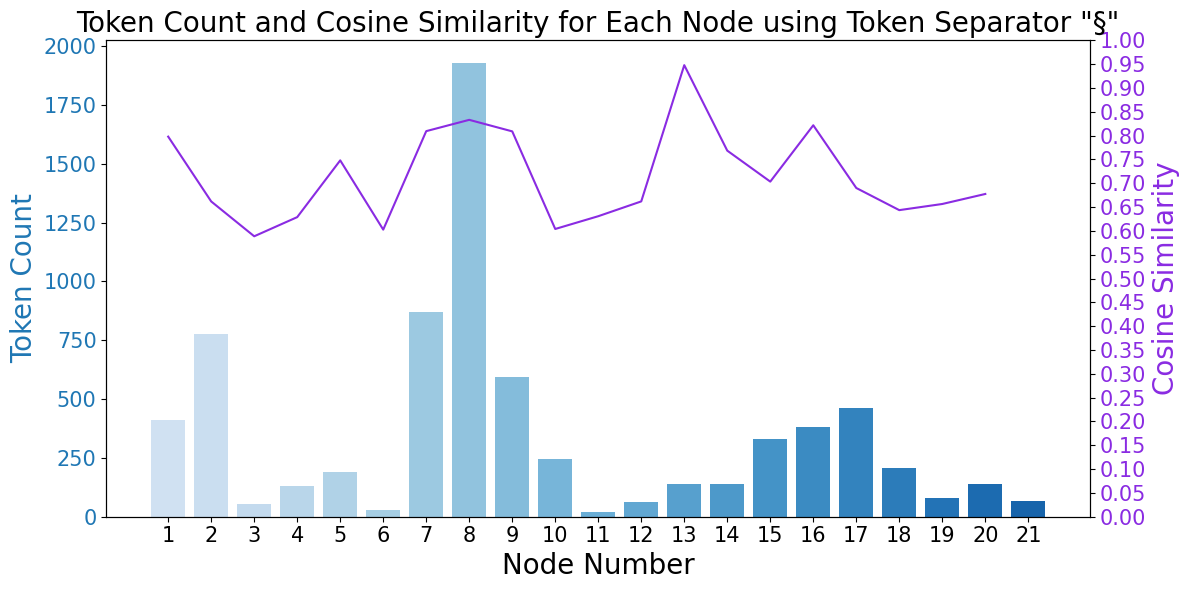

Token Counts - Mean: 345.2857142857143, Median: 191.0
Similarity Scores - Mean: 0.7142497897148132, Median: 0.6837730407714844


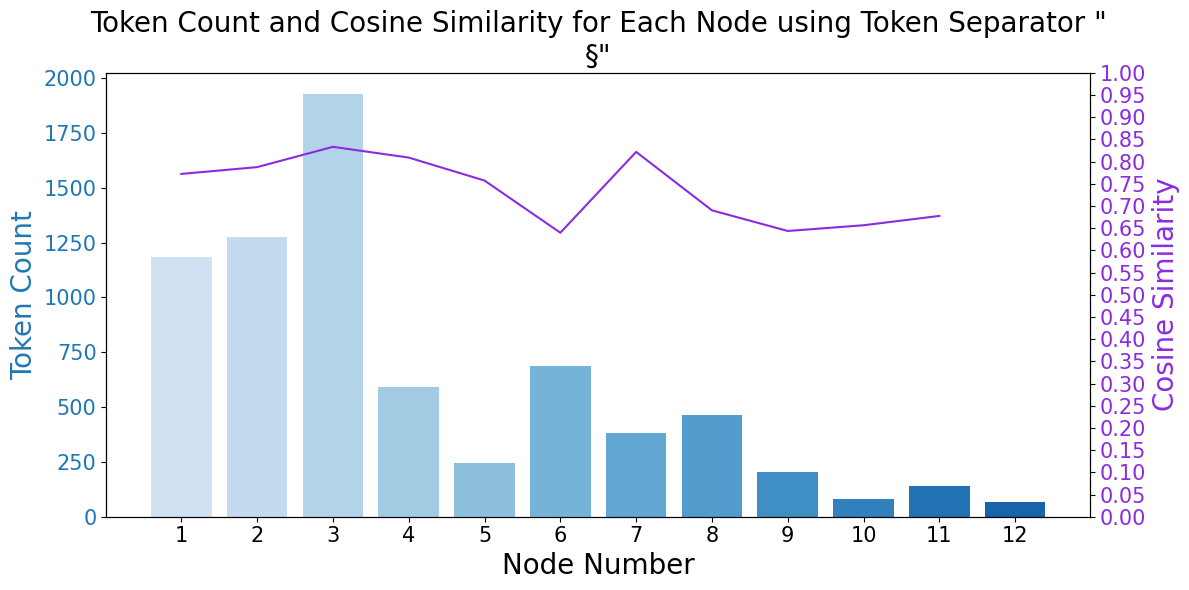

Token Counts - Mean: 604.1666666666666, Median: 421.0
Similarity Scores - Mean: 0.7352308034896851, Median: 0.7571172714233398


In [131]:
words_to_try = ["§", "\n§"]
for word in words_to_try:
    process_and_plot(docs, delimiter=word)
#process_and_plot(docs, delimiter="Requirements")

In [ ]:

index = VectorStoreIndex.from_documents(docs, transformations=[splitter])
chat_engine = index.as_chat_engine()

text_nodes = splitter(docs)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

testset = QATestset.load("../giskard_test_sets/LL144_275.jsonl")
#testset = QATestset.load("../giskard_test_sets/LL144_300_balanced_first_5.jsonl")
retriever = index.as_retriever(similarity_top_k=3)



def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)


def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]
    #print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )


report = evaluate(get_answer_fn,
                  testset=testset,
                  knowledge_base=knowledge_base,
                  metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

report.to_html('separator_results.html')
results = report.to_pandas()
results.to_csv('separator_results.csv', index=False)
